In [2]:
# %%
import pandas as pd
import holidays
import numpy as np
from itertools import product
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import Dataset, DataLoader
from math import radians, sin, cos, sqrt, atan2
import io
import requests
import re
import time
import geopandas as gpd
from shapely.geometry import Point
from dateutil.relativedelta import relativedelta

print('시작')
# CSV 파일 읽기 (현재 디렉토리에 업로드한 경우)
df = pd.read_csv('train_call_119.csv')
df_cat = pd.read_csv('train_cat_119.csv')
df_origin = df
df_cat_origin = df_cat

# 정수형 날짜를 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['call119_train.tm'].astype(str), format='%Y%m%d')
df_cat['date'] = pd.to_datetime(df_cat['cat119_train.tm'].astype(str), format='%Y%m%d')

df['call119_train.sub_address'] = df['call119_train.sub_address'].replace('일광면', '일광읍') # 일광면 -> 일광읍
df['call119_train.sub_address'] = df['call119_train.sub_address'].replace('정관면', '정관읍')
df_cat['cat119_train.sub_address'] = df_cat['cat119_train.sub_address'].replace('일광면', '일광읍')
df_cat['cat119_train.sub_address'] = df_cat['cat119_train.sub_address'].replace('정관면', '정관읍')
df.loc[(df['call119_train.sub_address'] == '송정동') & (df['call119_train.address_gu'] == '강서구'), 'call119_train.sub_address'] = '송정동_강서구'
df.loc[(df['call119_train.sub_address'] == '송정동') & (df['call119_train.address_gu'] == '해운대구'), 'call119_train.sub_address'] = '송정동_해운대구'
df_cat.loc[(df_cat['cat119_train.sub_address'] == '송정동') & (df_cat['cat119_train.address_gu'] == '강서구'), 'cat119_train.sub_address'] = '송정동_강서구'
df_cat.loc[(df_cat['cat119_train.sub_address'] == '송정동') & (df_cat['cat119_train.address_gu'] == '해운대구'), 'cat119_train.sub_address'] = '송정동_해운대구'


# 항목 변수, 부산광역시 변수, tm 변수 삭제
drop_indices = [0,1,2]
cols_to_drop = [df_cat.columns[i] for i in drop_indices]
df_cat = df_cat.drop(columns=cols_to_drop)
cols_to_drop = [df.columns[i] for i in drop_indices]
df = df.drop(columns=cols_to_drop)

# 1. 교통사고는 형태별로 분리된 이름 부여
df_cat_mod = df_cat.copy()

# 교통사고만 형태별로 구분 (ex: 구조_교통사고, 구급_교통사고
df_cat_mod['sub_cat_modified'] = df_cat_mod.apply(
    lambda row: f"{row['cat119_train.cat']}_" + row['cat119_train.sub_cat']
    if row['cat119_train.sub_cat'] == '교통사고' else row['cat119_train.sub_cat'],
    axis=1
)

# 1. 100건 이상인 신고종별만 필터링
valid_subcats = (
    df_cat_mod['sub_cat_modified']
    .value_counts()
    .loc[lambda x: x >= 100]
    .index
)
df_cat_mod = df_cat_mod[df_cat_mod['sub_cat_modified'].isin(valid_subcats)]

# 2. 피벗
df_cat_pivot = df_cat_mod.pivot_table(
    index=['date', 'cat119_train.address_gu', 'cat119_train.sub_address'],
    columns='sub_cat_modified',
    values='cat119_train.call_count',
    aggfunc='sum',
    fill_value=0
).reset_index()

# 3. df와 merge
df_merged = pd.merge(
    df,
    df_cat_pivot,
    left_on=['date', 'call119_train.address_gu', 'call119_train.sub_address'],
    right_on=['date', 'cat119_train.address_gu', 'cat119_train.sub_address'],
    how='left'
).drop(columns=['cat119_train.address_gu', 'cat119_train.sub_address'])

# 4. 결측치 처리 NaN -> 0
df_merged.fillna(0, inplace=True)

# 최종 결과
df = df_merged

# %%
# 1. 날짜, 구, 법정동 리스트 추출
unique_dates = df['date'].dropna().unique()
unique_gu = df['call119_train.address_gu'].dropna().unique()

# 2. 구별 법정동 매핑 생성
gu_dong_map = df.groupby('call119_train.address_gu')['call119_train.sub_address'].unique().to_dict()

# 3. 날짜 × 구 × 법정동 조합 생성
full_rows = []
for date in unique_dates:
    for gu in unique_gu:
        for dong in gu_dong_map[gu]:
            full_rows.append((date, gu, dong))

# 데이터프레임으로 변환
full_df = pd.DataFrame(full_rows, columns=['date', 'call119_train.address_gu', 'call119_train.sub_address'])

# 4. 원래 신고건수 데이터와 병합 (신고건수가 없는 곳은 0으로 처리)
merged_df = pd.merge(full_df, df, on=['date', 'call119_train.address_gu', 'call119_train.sub_address'], how='left')

# 신고건수가 없는 경우 0으로 채움
merged_df['call119_train.call_count'] = merged_df['call119_train.call_count'].fillna(0).astype(int)
df = merged_df

# 1. 각 (구, 동) 조합별로 가장 많이 등장한 stn 값을 매핑
stn_map = (
    df.dropna(subset=['call119_train.stn'])  # 결측 제거
      .groupby(['call119_train.address_gu', 'call119_train.sub_address'])['call119_train.stn']
      .agg(lambda x: x.mode().iloc[0])  # 가장 많이 등장한 stn (mode)
      .reset_index()
)

# 2. 기존 데이터프레임에 merge해서 stn 보완
df = df.merge(stn_map, on=['call119_train.address_gu', 'call119_train.sub_address'], how='left', suffixes=('', '_filled'))

# 3. stn 변수 채우기
df['call119_train.stn'] = df['call119_train.stn'].fillna(df['call119_train.stn_filled'])

# 4. 보조 컬럼 제거
df.drop(columns=['call119_train.stn_filled'], inplace=True)

# negative 데이터의 신고건수 NaN->0으로 대체
# 신고 유형 컬럼 리스트 정의
category_cols = [
  '구급_교통사고', '구급기타', '구조_교통사고',
       '대민지원', '부상', '산악사고', '상황출동', '수난사고', '업무운행', '자연재해', '지원출동(풍수해)'
]

# 이들에 대해서만 NaN을 0으로 대체
df[category_cols] = df[category_cols].fillna(0)


print('공휴일 변수 시작')
# 한국 공휴일 객체 생성
kr_holidays = holidays.KR(years=[2020, 2021,2022, 2023])  # 필요한 연도 지정
df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = df['weekday'] >= 5
# 공휴일 여부
holiday_dates = pd.to_datetime(list(kr_holidays.keys()))
df['is_holiday'] = df['date'].isin(holiday_dates)
# 주말 또는 공휴일 → 쉬는 날
df['is_dayoff'] = df['is_weekend'] | df['is_holiday']
# 필요없는 컬럼 삭제
df = df.drop(columns=['weekday', 'is_weekend', 'is_holiday'])
df_day = df[['date','is_dayoff']]
df_day_duple = df_day.groupby('date', as_index=False).agg({'is_dayoff': 'first'})
# 다음 날의 is_holiday 값 참조
df_day_duple['is_predayoff'] = df_day_duple['is_dayoff']
df_day_duple['is_predayoff'] = (
    df_day_duple['is_dayoff'].shift(-1)
    .fillna(False)
    .astype('bool')
)
# 머지
df_merged = pd.merge(
    df,           # 원본 데이터
    df_day_duple[['date','is_predayoff']],          # 요약된 날짜별 정보
    on='date',             # 날짜를 기준으로
    how='left'             # 원본 기준 병합
)
df=df_merged


print('거리두기 변수 시작')
############################################ 거리두기 변수 생성
def get_distancing_features(date_str):
    """
    날짜 문자열을 입력받아, 해당 날짜의 거리두기 유무 및 강도를 반환.
    거리두기 미실행 → (0, 0)
    거리두기 시행 → (1, 단계숫자)
    """
    date = pd.to_datetime(date_str)

    if pd.Timestamp("2020-05-01") <= date <= pd.Timestamp("2020-08-16"):
        return pd.Series({'distancing_on': 1, 'distancing_strength': 1})
    elif pd.Timestamp("2020-08-17") <= date <= pd.Timestamp("2020-10-31"):
        return pd.Series({'distancing_on': 1, 'distancing_strength': 2})
    elif pd.Timestamp("2021-05-01") <= date <= pd.Timestamp("2021-05-24"):
        return pd.Series({'distancing_on': 1, 'distancing_strength': 2})
    elif pd.Timestamp("2021-05-25") <= date <= pd.Timestamp("2021-06-21"):
        return pd.Series({'distancing_on': 1, 'distancing_strength': 1.5})
    elif pd.Timestamp("2021-06-22") <= date <= pd.Timestamp("2021-07-07"):
        return pd.Series({'distancing_on': 1, 'distancing_strength': 1})
    elif pd.Timestamp("2021-07-08") <= date <= pd.Timestamp("2021-07-19"):
        return pd.Series({'distancing_on': 1, 'distancing_strength': 2})
    elif pd.Timestamp("2021-07-20") <= date <= pd.Timestamp("2021-08-09"):
        return pd.Series({'distancing_on': 1, 'distancing_strength': 3})
    elif pd.Timestamp("2021-08-10") <= date <= pd.Timestamp("2021-09-05"):
        return pd.Series({'distancing_on': 1, 'distancing_strength': 4})
    elif pd.Timestamp("2021-09-06") <= date <= pd.Timestamp("2021-10-31"):
        return pd.Series({'distancing_on': 1, 'distancing_strength': 3})
    else:
        return pd.Series({'distancing_on': 0, 'distancing_strength': 0})

df[['distancing_on', 'distancing_strength']] = df['date'].apply(get_distancing_features)
############################################ 거리두기 변수 생성


print('해수욕장 개장여부 변수 시작')
##################################### 해수욕장 개장 여부 추가
# 문자열을 날짜로 파싱
def to_date(date_str):
    return pd.to_datetime(date_str)

# 각 동 그룹별 개장 기간 정보
beach_open_periods = {
    '우동': {
        2020: ('2020-06-01', '2020-08-21'),
        2021: ('2021-06-01', '2021-08-10'),
        2022: ('2022-06-02', '2022-08-31'),
        2023: ('2023-06-01', '2023-08-31'),
        2024: ('2024-06-01', '2024-08-31'),
    },
    '송정동_해운대구': {
        2020: ('2020-06-01', '2020-08-21'),
        2021: ('2021-06-01', '2021-08-10'),
        2022: ('2022-06-02', '2022-08-31'),
        2023: ('2023-06-01', '2023-08-31'),
        2024: ('2024-06-01', '2024-08-31'),
    },
    '광안동': {
        2020: ('2020-07-01', '2020-08-21'),
        2021: ('2021-07-01', '2021-08-10'),
        2022: ('2022-07-01', '2022-08-31'),
        2023: ('2023-07-01', '2023-08-31'),
        2024: ('2024-07-01', '2024-08-31'),
    },
    '다대동': {
        2020: ('2020-07-01', '2020-08-21'),
        2021: ('2021-07-01', '2021-08-10'),
        2022: ('2022-07-01', '2022-08-31'),
        2023: ('2023-07-01', '2023-08-31'),
        2024: ('2024-07-01', '2024-08-31'),
    },
    '을숙읍': {
        2020: ('2020-07-01', '2020-08-21'),
        2021: ('2021-07-01', '2021-08-10'),
        2022: ('2022-07-01', '2022-08-31'),
        2023: ('2023-07-01', '2023-08-31'),
        2024: ('2024-07-01', '2024-08-31'),
    },
    '장안읍': {
        2020: ('2020-07-01', '2020-08-21'),
        2021: ('2021-07-01', '2021-08-10'),
        2022: ('2022-07-01', '2022-08-31'),
        2023: ('2023-07-01', '2023-08-31'),
        2024: ('2024-07-01', '2024-08-31'),
    },
    '암남동': {
        2020: ('2020-07-01', '2020-08-21'),
        2021: ('2021-07-01', '2021-08-09'),
        2022: ('2022-07-01', '2022-08-31'),
        2023: ('2023-07-01', '2023-08-31'),
        2024: ('2024-07-01', '2024-08-31'),
    },
}

def is_beach_open(row):
    dong = row['call119_train.sub_address']
    date = row['date']
    year = date.year

    if dong in beach_open_periods and year in beach_open_periods[dong]:
        start_str, end_str = beach_open_periods[dong][year]
        start_date = to_date(start_str)
        end_date = to_date(end_str)
        return start_date <= date <= end_date
    else:
        return False

# 개장 여부 컬럼 생성
df['beach_open'] = df.apply(is_beach_open, axis=1)

print('인구수 변수 시작')
# 인구 엑셀 파일 불러오기
df_pop = pd.read_csv("법정동별_인구통계.csv",encoding='euc-kr')
df_pop = df_pop.drop(columns=['idx'])
df_pop['시점'] = pd.to_datetime(df_pop['시점']).dt.strftime('%b-%y')  # 예: May-20
df_pop['시점'] = df_pop['시점'].astype(str).str.strip()

# df1 날짜를 월 단위로 변환
df1 = df
df1['시점'] = pd.to_datetime(df1['date']).dt.strftime('%b-%y')  # 예: May-20
df1['시점'] = df1['시점'].astype(str)  # 또는 .dt.strftime('%b-%y') 형태도 가능

# 컬럼명 통일
df_pop.rename(columns={'지역동': 'call119_train.sub_address'}, inplace=True)

# 병합
df_merged = df1.merge(
    df_pop,
    how='left',
    on=['시점', 'call119_train.sub_address']
)

df = df_merged


# 인구 엑셀 파일 불러오기
df_pop = pd.read_csv("법정동별_인구통계.csv",encoding='euc-kr')
df_pop = df_pop.drop(columns=['idx'])
df_pop['시점'] = df_pop['시점'].astype(str).str.strip()
df_pop['시점'] = pd.to_datetime(df_pop['시점']).dt.strftime('%b-%y')  # 예: May-20
df_pop['시점'] = pd.to_datetime(df_pop['시점'], format='%b-%y') + pd.DateOffset(months=1)
df_pop['시점'] = df_pop['시점'].dt.strftime('%b-%y')


print('위도/경도 변수 시작')
# 1. 법정동 shp 불러오기
gdf = gpd.read_file("LSMD_ADM_SECT_UMD_26_202505.shp", encoding='euc-kr')

# 2. 위경도 좌표계로 변환
gdf = gdf.to_crs(epsg=4326)

# 3. 중심 좌표 추출
gdf['위도'] = gdf.geometry.centroid.y
gdf['경도'] = gdf.geometry.centroid.x
gdf = gdf[['EMD_NM','위도','경도']]

df_filtered = gdf[gdf['EMD_NM'].str.endswith('가')]
df_filtered_동 = gdf[~gdf['EMD_NM'].str.endswith('가')]

# 가정: df['EMD_NM'], df['위도'], df['경도']가 존재

# 1️⃣ EMD_NM에서 숫자+‘가’를 제거하여 대표 동 이름 만들기
def clean_dong_name(name):
    return re.sub(r'\d+가$', '', name)  # 예: 보수동1가 → 보수동, 남포동3가 → 남포동

df_filtered['EMD_NM'] = df_filtered['EMD_NM'].apply(clean_dong_name)

# 2️⃣ 동 이름별로 위도/경도 평균 구하기
df_grouped = df_filtered.groupby('EMD_NM', as_index=False)[['위도', '경도']].mean()

df_merged = pd.concat([df_grouped, df_filtered_동], ignore_index=True)
# 위도 값을 기준으로 조건부 변경
df_merged.loc[(df_merged['EMD_NM'] == '송정동') & (df_merged['위도'] > 35.1), 'EMD_NM'] = '송정동_해운대구'
df_merged.loc[(df_merged['EMD_NM'] == '송정동') & (df_merged['위도'] < 35.1), 'EMD_NM'] = '송정동_강서구'

df['EMD_NM'] = df['call119_train.sub_address']

# 동 이름 기준으로 위경도 병합
df_m = df.merge(df_merged, how='left', on='EMD_NM')
df = df_m.drop(columns=['EMD_NM'])


# Haversine 거리 함수
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def spatial_impute_by_date(df, target_col, date_col='date', lat_col='위도', lon_col='경도', K=3):
    for date in df[date_col].unique():  # 날짜별 반복
        daily_data = df[df[date_col] == date]

        for idx, row in daily_data[daily_data[target_col].isna()].iterrows():
            lat, lon = row[lat_col], row[lon_col]
            neighbors = daily_data[daily_data[target_col].notna()].copy()

            if neighbors.empty:
                continue  # 이 날짜에 관측값이 하나도 없으면 넘어감

            neighbors['distance'] = neighbors.apply(
                lambda r: haversine(lat, lon, r[lat_col], r[lon_col]), axis=1)

            nearest = neighbors.nsmallest(K, 'distance')
            imputed_value = nearest[target_col].mean()
            df.at[idx, target_col] = imputed_value
    return df

# 날씨관련 컬럼만 stn그룹별 평균으로 결측치 대체
target_cols = ['call119_train.ta_max', 'call119_train.ta_min','call119_train.ta_max_min'
,'call119_train.hm_min','call119_train.hm_max','call119_train.ws_max', 'call119_train.ws_ins_max', 'call119_train.rn_day']
# 1. -99를 NaN으로 변경
df[target_cols] = df[target_cols].replace(-99, np.nan)
# 2. 날짜(date)와 기상관측소(stn)별로 평균으로 결측치 대체
df[target_cols] = df.groupby(['date', 'call119_train.stn'])[target_cols].transform(
    lambda x: x.fillna(x.mean())
)
# 위도 경도기반 날씨데이터 2차 보정
for col in target_cols:
    df = spatial_impute_by_date(df, col)


# 날씨관련 컬럼만 stn그룹별 평균으로 결측치 대체
target_cols = ['ta_max', 'ta_min','ta_max_min','hm_min','hm_max','ws_max', 'ws_ins_max', 'rn_day']


########################################################### 체감온도 변수 생성
def calculate_tw(ta, rh):
    return (
        ta * np.arctan(0.151977 * np.sqrt(rh + 8.313659)) +
        np.arctan(ta + rh) -
        np.arctan(rh - 1.6763) +
        0.00391838 * rh**1.5 * np.arctan(0.023101 * rh) -
        4.686035
    )

def calculate_apparent_temp(ta, tw):
    return (
        -0.2442 + 0.55399 * tw + 0.45535 * ta
        - 0.0022 * (tw**2) + 0.00278 * tw * ta + 3.0
    )

# 체감온도 컬럼 추가
df['real_ta'] = calculate_apparent_temp(df['call119_train.ta_max'], calculate_tw(df['call119_train.ta_max'], df['call119_train.hm_max']))
############################################################## 체감온도 변수 생성

df.rename(columns={'call119_train.address_gu': 'address_gu'}, inplace=True)
df.rename(columns={'call119_train.sub_address': 'sub_address'}, inplace=True)
df.rename(columns={'call119_train.call_count': 'call_count'}, inplace=True)
df.rename(columns={'call119_train.stn': 'STN'}, inplace=True)
df.rename(columns={'call119_train.ta_max': 'ta_max'}, inplace=True)
df.rename(columns={'call119_train.ta_min': 'ta_min'}, inplace=True)
df.rename(columns={'call119_train.ta_max_min': 'ta_max_min'}, inplace=True)
df.rename(columns={'call119_train.hm_min': 'hm_min'}, inplace=True)
df.rename(columns={'call119_train.hm_max': 'hm_max'}, inplace=True)
df.rename(columns={'call119_train.ws_max': 'ws_max'}, inplace=True)
df.rename(columns={'call119_train.ws_ins_max': 'ws_ins_max'}, inplace=True)
df.rename(columns={'call119_train.rn_day': 'rn_day'}, inplace=True)
# 중복행 제거. 정관면->정관읍으로 변경하면서 생긴 중복데이터 3개
drop_locs = [5438, 7734, 34735]
df = df.drop(index=drop_locs)


print('태풍영향 여부 변수 시작')
def get_typhoon_data(year, url_base, authKey):
    url = f"{url_base}?YY={year}&disp=0&help=0&authKey={authKey}"
    response = requests.get(url)
    raw_data = response.content.decode('euc-kr')

    lines = raw_data.strip().split('\n')
    lines = [line for line in lines if not line.startswith('#START7777') and not line.startswith('#7777END')]
    lines = lines[2:]  # 헤더 제거

    data = []
    for line in lines:
        match = re.match(r'(\d{4})\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d{12})\s+(\d{12})\s+(\S+)\s+(\S+)\s+(.+)', line)
        if match:
            year, seq, now, eff, tm_st, tm_ed, typ_name, typ_en, rem = match.groups()
            data.append({
                'year': int(year),
                'seq': int(seq),
                'now': int(now),
                'eff': int(eff),
                'tm_st': tm_st,
                'tm_ed': tm_ed,
                'typ_name': typ_name,
                'typ_en': typ_en,
                'rem': rem.strip()
            })
        else:
            print(f"[{year}] 파싱 실패: {line}")

    return pd.DataFrame(data)




# === 여기부터 메인 코드 ===

url_base = 'https://apihub.kma.go.kr/api/typ01/url/typ_lst.php'
authKey = 'fbywp9QpQdK8sKfUKUHSpg'

all_dataframes = []

for year in range(2020, 2025):  # 2020~2024까지
    print(f"Processing year: {year}")
    df_typhoon_tmp = get_typhoon_data(year, url_base, authKey)
    all_dataframes.append(df_typhoon_tmp)
    time.sleep(0.5)  # 너무 빠르게 호출하지 않도록 잠깐 쉬어줌

# 모든 데이터 합치기
final_df = pd.concat(all_dataframes, ignore_index=True)
final_df = final_df[final_df['eff'] == 1]

def parse_typhoon_detail(raw_text):
    # START/END 제거
    lines = raw_text.strip().split('\n')
    lines = [line for line in lines if not line.startswith('#START7777') and not line.startswith('#7777END')]

    # 헤더 두 줄 제거
    lines = lines[2:]

    # 본문만 확보
    data_str = '\n'.join(lines)

    # LOC 필드가 콤마를 포함하고 있어 기본 csv 파싱은 깨질 수 있으므로:
    # LOC 이후의 ED25, ER25는 LOC 바로 뒤에 항상 2개 필드가 고정으로 나옴 (쉼표도 고정)
    # 일단 간단히 LOC까지는 수동으로 파싱하고 이후는 뒤에 2개 필드만 분리하는 방식 가능

    # 간단한 접근: LOC 를 통째로 하나의 문자열로 보고, 뒤에 ED25, ER25만 추가 분리

    # LOC 가 있는 줄에서 LOC 이후 부분을 = 기준으로 나누자 (맨 끝에 항상 ,= 으로 끝남)
    cleaned_lines = []
    for line in lines:
        if line.endswith(',='):
            line = line[:-2]  # 마지막 ,= 제거
        cleaned_lines.append(line)

    # 전체를 다시 하나의 csv처럼 만듦
    csv_data = '\n'.join(cleaned_lines)

    # IO String으로 만들어서 pandas read_csv로 바로 파싱 (header 없음)
    df = pd.read_csv(io.StringIO(csv_data), header=None)

    # 컬럼명 지정
    df.columns = [
        'FT','YY','TYP','SEQ','TMD','TYP_TM','FT_TM','LAT','LON','DIR','SP','PS','WS',
        'RAD15','RAD25','RAD','ED15','ER15','LOC','ED25','ER25R'
    ]

    # 날짜 파싱
    df['TYP_TM'] = pd.to_datetime(df['TYP_TM'], format='%Y%m%d%H%M')
    df['FT_TM']  = pd.to_datetime(df['FT_TM'], format='%Y%m%d%H%M')

    return df

# === API 기본설정 ===
authKey = "fbywp9QpQdK8sKfUKUHSpg"
url_base = "https://apihub.kma.go.kr/api/typ01/url/typ_data.php"

# === 반복 호출 및 수집 ===
all_dataframes = []

for idx, row in final_df.iterrows():
    year = row['year']
    typ = row['seq']
    name = row['typ_name']

    print(f"Processing {year}년도 {typ}번째 태풍 ({name})")

    url = f"{url_base}?YY={year}&typ={typ}&disp=1&help=0&authKey={authKey}"
    response = requests.get(url)
    raw_text = response.content.decode('euc-kr')

    df_detail = parse_typhoon_detail(raw_text)
    df_detail['NAME'] = name  # 태풍이름 추가
    all_dataframes.append(df_detail)

    time.sleep(0.5)  # 호출 너무 빠르지 않게 약간 쉬어주기

# === 전체 병합 ===
final_df = pd.concat(all_dataframes, ignore_index=True)
final_df['date'] = final_df['TYP_TM'].dt.date
drop_col = ['FT','YY','TYP','SEQ','TMD','TYP_TM','FT_TM','DIR','SP','PS','RAD','ED15','ER15','LOC','ED25','ER25R']
df_typhoon = final_df.drop(columns=drop_col)
# LAT가 25~40 사이인 데이터만 남김
df_typhoon = df_typhoon[(df_typhoon['LAT'] > 25) & (df_typhoon['LAT'] < 40)].reset_index(drop=True)


# ✅ 1. Haversine 거리계산 함수
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # 지구 반경 km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# ✅ 2. 영향판정 함수
def determine_impact(distance, rad15, rad25):
    if pd.isna(rad15) or pd.isna(rad25):
        return np.nan  # 결측치 있을 경우
    if distance <= rad25:
        return 2
    elif distance <= rad15:
        return 1
    else:
        return 0

# ✅ 3. 태풍 데이터 일 단위 집계
# RAD15, RAD25 결측치 처리 (-999 → np.nan)
df_typhoon['RAD15'] = df_typhoon['RAD15'].replace(-999, np.nan)
df_typhoon['RAD25'] = df_typhoon['RAD25'].replace(-999, np.nan)

df['date'] = pd.to_datetime(df['date']).dt.date
df_typhoon['date'] = pd.to_datetime(df_typhoon['date']).dt.date

# ✅ 5. 각 날짜별 거리 계산 및 영향판정

impact_results = []

for idx, weather_row in df.iterrows():
    w_date = weather_row['date']
    w_lat = weather_row['위도']
    w_lon = weather_row['경도']

    # 같은 날짜 태풍만 필터
    today_typhoons = df_typhoon[df_typhoon['date'] == w_date]

    impact_today = 0  # 기본 영향 없음

    for _, ty_row in today_typhoons.iterrows():
        t_lat = ty_row['LAT']
        t_lon = ty_row['LON']
        rad15 = ty_row['RAD15']
        rad25 = ty_row['RAD25']

        if pd.isna(rad15) or pd.isna(rad25):
            continue  # 결측치는 건너뜀

        distance = haversine(w_lat, w_lon, t_lat, t_lon)
        impact = determine_impact(distance, rad15, rad25)

        if impact == 2:  # 폭풍권 들어오면 즉시 종료 (최우선)
            impact_today = 2
            break
        elif impact == 1:
            impact_today = max(impact_today, 1)

    impact_results.append(impact_today)

# ✅ 6. 결과 컬럼 추가
df['typhoon_impact'] = impact_results


df['date'] = pd.to_datetime(df['date'])

# ✅ 날짜 기반 주기 특성 추가
for df_ in [df]:
    df_['weekday'] = df_['date'].dt.weekday
    df_['month'] = df_['date'].dt.month
    df_['weekday_sin'] = np.sin(2 * np.pi * df_['weekday'] / 7)
    df_['weekday_cos'] = np.cos(2 * np.pi * df_['weekday'] / 7)
    df_['month_sin'] = np.sin(2 * np.pi * df_['month'] / 12)
    df_['month_cos'] = np.cos(2 * np.pi * df_['month'] / 12)
    df_.drop(columns=['weekday', 'month'], inplace=True)

# ✅ 날짜, 범주형 컬럼 제거
drop_cols = [ '시점', 'STN']
df = df.drop(columns=drop_cols)


#%%
print('1일전 2일전 변수 시작')
# 사용할 컬럼 리스트 (중복제거)
cols_to_lag = ['ta_max', 'ta_min', 'ta_max_min', 'hm_min', 'hm_max',
               'ws_max', 'ws_ins_max', 'rn_day',
               'distancing_strength', 'beach_open',
               'real_ta', 'typhoon_impact']

# 먼저 동별로 그룹화해서 날짜 순으로 정렬
df = df.sort_values(['sub_address', 'date'])

# 그룹별로 lag 변수 생성
for col in cols_to_lag:
    for lag in [1, 2]:
        lag_col_name = f"{col}_lag{lag}"
        df[lag_col_name] = df.groupby('sub_address')[col].shift(lag)

# 반복문으로 lag 컬럼들 처리 (NaN 채우기)
for col in cols_to_lag:
    for lag in [1, 2]:
        lag_col = f"{col}_lag{lag}"

        df[lag_col] = df[lag_col].fillna(df[col])

# %%
df.to_csv('train_unscaled.csv')
# %%

시작
공휴일 변수 시작
거리두기 변수 시작


C:\Users\juyeo\AppData\Local\Temp\ipykernel_336\3616439301.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


해수욕장 개장여부 변수 시작
인구수 변수 시작
위도/경도 변수 시작


C:\Users\juyeo\AppData\Local\Temp\ipykernel_336\3616439301.py:329: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['위도'] = gdf.geometry.centroid.y
C:\Users\juyeo\AppData\Local\Temp\ipykernel_336\3616439301.py:330: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['경도'] = gdf.geometry.centroid.x
C:\Users\juyeo\AppData\Local\Temp\ipykernel_336\3616439301.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['EMD_NM'] = df_filtered['EMD_NM'].apply(clean_dong_

태풍영향 여부 변수 시작
Processing year: 2020
Processing year: 2021
Processing year: 2022
Processing year: 2023
Processing year: 2024
Processing 2020년도 5번째 태풍 (장미)
Processing 2020년도 9번째 태풍 (마이삭)
Processing 2020년도 10번째 태풍 (하이선)
Processing 2021년도 12번째 태풍 (오마이스)
Processing 2022년도 11번째 태풍 (힌남노)
Processing 2023년도 6번째 태풍 (카눈)
1일전 2일전 변수 시작


C:\Users\juyeo\AppData\Local\Temp\ipykernel_336\3616439301.py:673: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[lag_col] = df[lag_col].fillna(df[col])


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

# Windows 환경에서 맑은 고딕 폰트 사용
font_name = 'Malgun Gothic'

# matplotlib에 폰트 적용
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

print("사용 폰트:", font_name)
print("폰트 등록 완료!")


사용 폰트: Malgun Gothic
폰트 등록 완료!


C:\Users\juyeo\AppData\Local\Temp\ipykernel_336\2794484511.py:48: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(distance, method='ward')


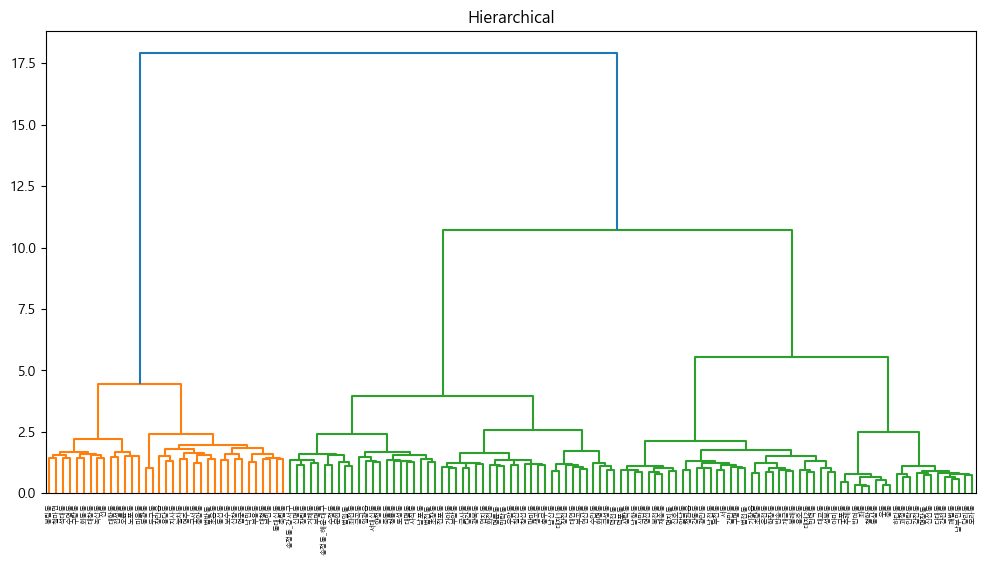


Cluster 1 포함 동 목록:
address_gu sub_address
       강서구         구랑동
       강서구         녹산동
       강서구         눌차동
       강서구         대항동
       강서구         동선동
       강서구         미음동
       강서구         범방동
       강서구         봉림동
       강서구         죽림동
       강서구         지사동
       강서구         천성동
       금정구         구서동
       금정구         노포동
       금정구         두구동
       금정구          선동
       금정구         오륜동
       금정구         회동동
       기장군         장안읍
       기장군         철마면
        남구         용당동
       동래구         낙민동
      부산진구         초읍동
       사상구         엄궁동
        서구        동대신동
        서구         부민동
        서구         부용동
       수영구         수영동
        중구         대창동
        중구         대청동
        중구         동광동
        중구         보수동
        중구         신창동
        중구         영주동
        중구         중앙동
      해운대구         석대동

Cluster 2 포함 동 목록:
address_gu sub_address
       강서구        대저1동
       강서구         생곡동
       강서구     송정동_강서구
       강서구         죽동동
       강서구       

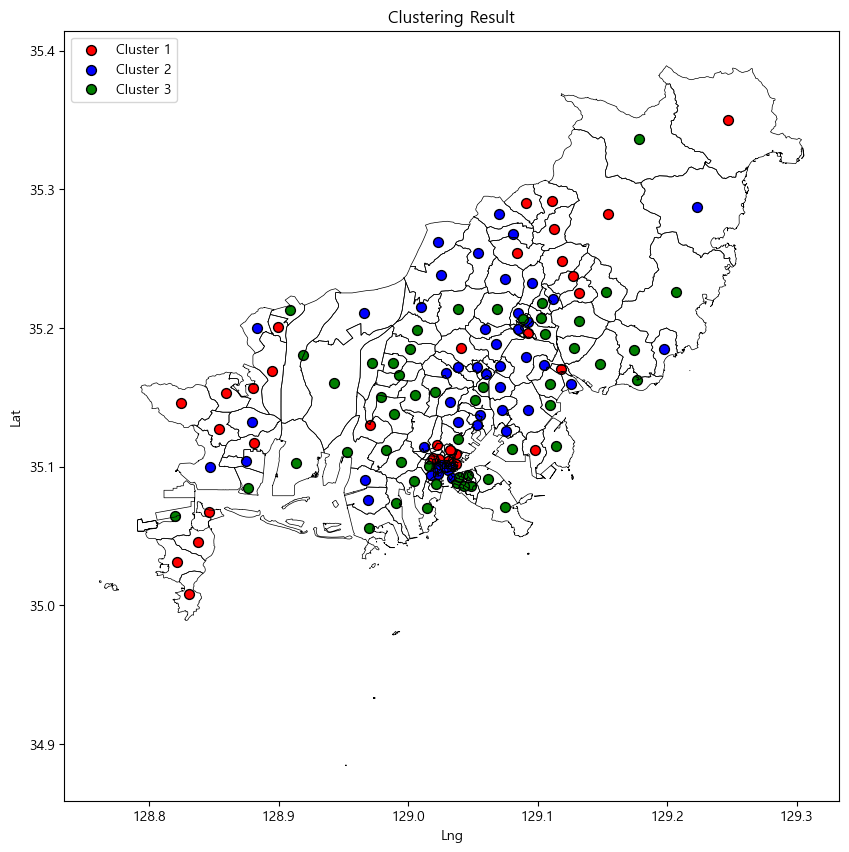

,date,address_gu,sub_address,ta_max,ta_min,ta_max_min,hm_min,hm_max,ws_max,ws_ins_max,...,beach_open_lag1,beach_open_lag2,real_ta_lag1,real_ta_lag2,typhoon_impact_lag1,typhoon_impact_lag2,cluster,cluster_1,cluster_2,cluster_3
0,2020-05-01,부산진구,가야동,24.8,16.6,8.2,63.7,87.5,4.3,7.8,...,False,False,27.295234,27.295234,0.0,0.0,2,0.0,1.0,0.0
1,2020-05-02,부산진구,가야동,24.6,17.5,7.1,69.2,89.9,4.0,6.6,...,False,False,27.295234,27.257818,0.0,0.0,2,0.0,1.0,0.0
2,2020-05-03,부산진구,가야동,18.4,15.8,2.6,85.2,98.6,5.1,8.4,...,False,False,27.257818,27.295234,0.0,0.0,2,0.0,1.0,0.0
3,2020-05-04,부산진구,가야동,27.7,17.0,10.7,62.5,99.3,4.1,5.8,...,False,False,21.434668,27.257818,0.0,0.0,2,0.0,1.0,0.0
4,2020-05-05,부산진구,가야동,20.2,14.2,6.0,67.6,88.9,4.3,6.8,...,False,False,31.142448,21.434668,0.0,0.0,2,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99355,2023-10-27,금정구,회동동,21.4,11.9,9.5,37.5,82.6,3.7,9.4,...,False,False,27.121192,25.943618,0.0,0.0,1,1.0,0.0,0.0
99356,2023-10-28,금정구,회동동,21.1,9.5,11.6,42.7,89.0,2.2,4.5,...,False,False,23.471208,27.121192,0.0,0.0,1,1.0,0.0,0.0
99357,2023-10-29,금정구,회동동,21.5,10.6,10.9,44.7,89.4,2.6,5.2,...,False,False,23.593103,23.471208,0.0,0.0,1,1.0,0.0,0.0
99358,2023-10-30,금정구,회동동,22.9,10.2,12.7,40.9,91.2,3.2,5.5,...,False,False,24.030740,23.593103,0.0,0.0,1,1.0,0.0,0.0


In [4]:
# clustering

#%% 전체 통합 파이프라인
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
import geopandas as gpd
import re
import matplotlib
from matplotlib import font_manager, rc


# ===============================
# 1. 데이터 로드 및 전처리
# ===============================
df = pd.read_csv('train_unscaled.csv', index_col=0)
df.columns

'''
구급_교통사고', '구급기타', '구조_교통사고', '대민지원', '부상', '산악사고', '상황출동', '수난사고',
       '업무운행', '자연재해', '지원출동(풍수해)', 'is_dayoff', 'is_predayoff',
'''
target_col = 'call_count'
cluster_num = 3

# ===============================
# 2. 위경도 처리 (법정동 shp 이용)
# ===============================
# ✅ GeoDataFrame 원본은 그대로 유지 (gdf_raw: 지도용)
gdf_raw = gpd.read_file("LSMD_ADM_SECT_UMD_26_202505.shp", encoding='euc-kr')
gdf_raw = gdf_raw.to_crs(epsg=4326)  # EPSG:4326으로 변환 (위경도 degree)

# ===============================
# 3. 클러스터링 수행
# ===============================

# Pivot table 생성
pivot = df.pivot_table(index='date', columns='sub_address',
                       values=target_col, aggfunc='sum')
pivot = pivot.fillna(0)

# 상관계수 → 거리변환
corr = pivot.corr()
corr = corr.fillna(0)
distance = 1 - corr
linkage = sch.linkage(distance, method='ward')

# 덴드로그램 시각화
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage, labels=corr.columns, leaf_rotation=90)
plt.title('Hierarchical')
plt.show()

# 클러스터 생성
clusters = fcluster(linkage, t=cluster_num, criterion='maxclust')
cluster_df = pd.DataFrame({
    'sub_address': corr.columns,
    'cluster': clusters
})

# ===============================
# 4. 클러스터 해석 준비
# ===============================

# 클러스터 결과와 구, 위경도 병합
address_info = df[['sub_address', 'address_gu', '위도', '경도']].drop_duplicates()
cluster_full = cluster_df.merge(address_info, on='sub_address', how='left')
# 클러스터별 포함된 동 목록 출력
for cluster_id in sorted(cluster_full['cluster'].unique()):
    subset = cluster_full[cluster_full['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} 포함 동 목록:")
    print(subset[['address_gu', 'sub_address']].sort_values(['address_gu', 'sub_address']).to_string(index=False))
# ===============================
# 5. 클러스터별 통계 해석
# ===============================

# 구별 동 분포
cluster_summary = cluster_full.groupby(['cluster', 'address_gu']).size().unstack(fill_value=0)
print("\n클러스터별 구별 동 분포:\n", cluster_summary)

# 신고건수 통계
df_clustered = df.merge(cluster_df, on='sub_address', how='left')
agg = df_clustered.groupby('cluster')[target_col].agg(['mean', 'std', 'max', 'min'])
print("\n클러스터별 신고건수 통계:\n", agg)

# ===============================
# 6. 부산 지도 + 클러스터 결과 통합 시각화
# ===============================

# 완전 안정 버전 (matplotlib 단독)
# 완전 안정 버전 (matplotlib 단독)
fig, ax = plt.subplots(figsize=(10, 10))

# 지도 경계선 그리기 (gdf_raw에서 geometry 이용)
for geom in gdf_raw.geometry:
    if geom.geom_type == 'Polygon':
        xs, ys = geom.exterior.xy
        ax.plot(xs, ys, color='black', linewidth=0.5)
    elif geom.geom_type == 'MultiPolygon':
        for poly in geom.geoms:
            xs, ys = poly.exterior.xy
            ax.plot(xs, ys, color='black', linewidth=0.5)

# 클러스터 점 찍기
colors = {1: 'red', 2: 'blue', 3: 'green'}
for cluster_id in sorted(cluster_full['cluster'].unique()):
    subset = cluster_full[cluster_full['cluster'] == cluster_id]
    ax.scatter(
        subset['경도'], subset['위도'],
        color=colors[cluster_id],
        label=f'Cluster {cluster_id}',
        s=50,
        edgecolors='black'
    )

plt.title('Clustering Result')
plt.xlabel('Lng')
plt.ylabel('Lat')
plt.legend()
plt.show()
#%%
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(df_clustered[['cluster']])  # 반드시 train으로만 fit

# 2. train 데이터 인코딩 적용
cluster_train_encoded = encoder.transform(df_clustered[['cluster']])

# 3. 인코딩된 결과를 데이터프레임으로 변환 (컬럼 이름도 생성)
encoded_columns = encoder.get_feature_names_out(['cluster'])
cluster_train_df = pd.DataFrame(cluster_train_encoded, columns=encoded_columns, index=df_clustered.index)

# 4. 기존 train 데이터와 병합
train_encoded = pd.concat([df_clustered, cluster_train_df], axis=1)

train_encoded.to_csv('train_clustered.csv',index=False)
#%%
train_encoded

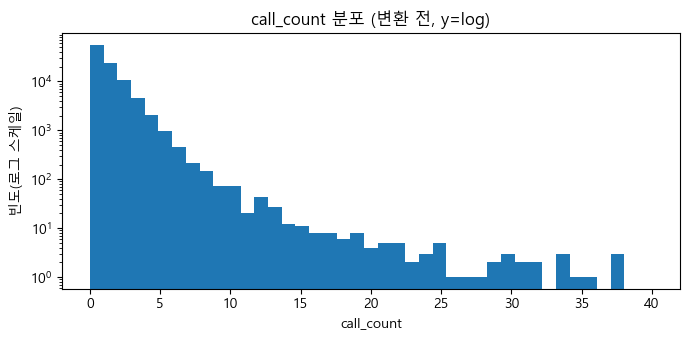

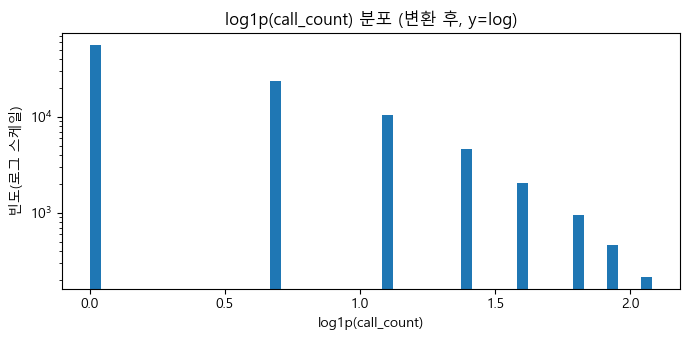

,call119_train.ta_max,call119_train.hm_min,call119_train.ws_max,call119_train.rn_day,call119_train.call_count
count,42924.000000,42924.000000,42924.000000,42924.000000,42924.000000
mean,26.025443,45.600601,4.422377,8.280265,1.916760
std,8.059514,43.425352,6.343533,27.216865,2.058855
min,-99.000000,-99.000000,-99.000000,-99.000000,1.000000
25%,23.600000,40.200000,3.400000,0.000000,1.000000
50%,26.600000,56.500000,4.200000,0.000000,1.000000
75%,29.400000,67.700000,5.500000,2.000000,2.000000
max,37.600000,99.500000,30.700000,259.200000,115.000000


In [5]:
# scale

#%%
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

train_scaled = pd.read_csv('train_clustered.csv', index_col=0)
train_scaled.columns
#%%
target_col = [
  '구급_교통사고', '구급기타', '구조_교통사고',
       '대민지원', '부상', '산악사고', '상황출동', '수난사고', '업무운행', '자연재해', '지원출동(풍수해)'
]

# 5. target 컬럼 log1p 변환
train_scaled[target_col] = np.log1p(train_scaled[target_col])


encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(train_scaled[['sub_address']])  # 반드시 train으로만 fit

# 2. train 데이터 인코딩 적용
sub_address_train_encoded = encoder.transform(train_scaled[['sub_address']])

# 3. 인코딩된 결과를 데이터프레임으로 변환 (컬럼 이름도 생성)
encoded_columns = encoder.get_feature_names_out(['sub_address'])
sub_address_train_df = pd.DataFrame(sub_address_train_encoded, columns=encoded_columns, index=train_scaled.index)

# 4. 기존 train 데이터와 병합
train_encoded = pd.concat([train_scaled, sub_address_train_df], axis=1)


train_encoded.to_csv('train_onehot_log1p.csv')
# %%


#%% call_count 분포 (원본 vs log1p) 콘솔 출력

col = 'call_count'

# 1) 원본 값 확보(아직 log1p 미적용이라고 가정)
before = pd.to_numeric(train_scaled[col], errors='coerce').dropna().to_numpy()

# 카운트 데이터인데 혹시 음수가 섞여 있으면 0으로 클리핑(안전장치)
if np.any(before < 0):
    print(f"[경고] {col}에 음수가 포함되어 0으로 클리핑합니다.")
    before = np.clip(before, 0, None)

# 2) log1p 변환
after = np.log1p(before)

# ─────────────────────────────────────────────────────────────
# (A) 원본 히스토그램: 오른쪽 꼬리 가시화를 위해 y축 로그 스케일
ub_before = np.nanpercentile(before, 99.8)  # 상위 0.5% 컷으로 상한 설정
ub_before = int(np.ceil(ub_before))
ub_before = max(40, min(ub_before, 500))   # 너무 작거나 큰 경우 가드

plt.figure(figsize=(7, 3.5))
plt.hist(before, bins=min(ub_before + 1, 200), range=(0, ub_before))
plt.yscale('log')
plt.title(f'{col} 분포 (변환 전, y=log)')
plt.xlabel(col)
plt.ylabel('빈도(로그 스케일)')
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# (B) log1p 후 히스토그램: y축 로그 스케일
ub_after = float(np.nanpercentile(after, 99.5))
right = max(1.0, ub_after)  # 최소 범위 확보

plt.figure(figsize=(7, 3.5))
plt.hist(after, bins=50, range=(0, right))
plt.yscale('log')
plt.title(f'log1p({col}) 분포 (변환 후, y=log)')
plt.xlabel(f'log1p({col})')
plt.ylabel('빈도(로그 스케일)')
plt.tight_layout()
plt.show()

#%%
df_info = pd.read_csv('train_call_119.csv')
pos = [3,6,8,10,11]                 # 1, 3, 6번째 컬럼
df_info.describe().iloc[:, pos]


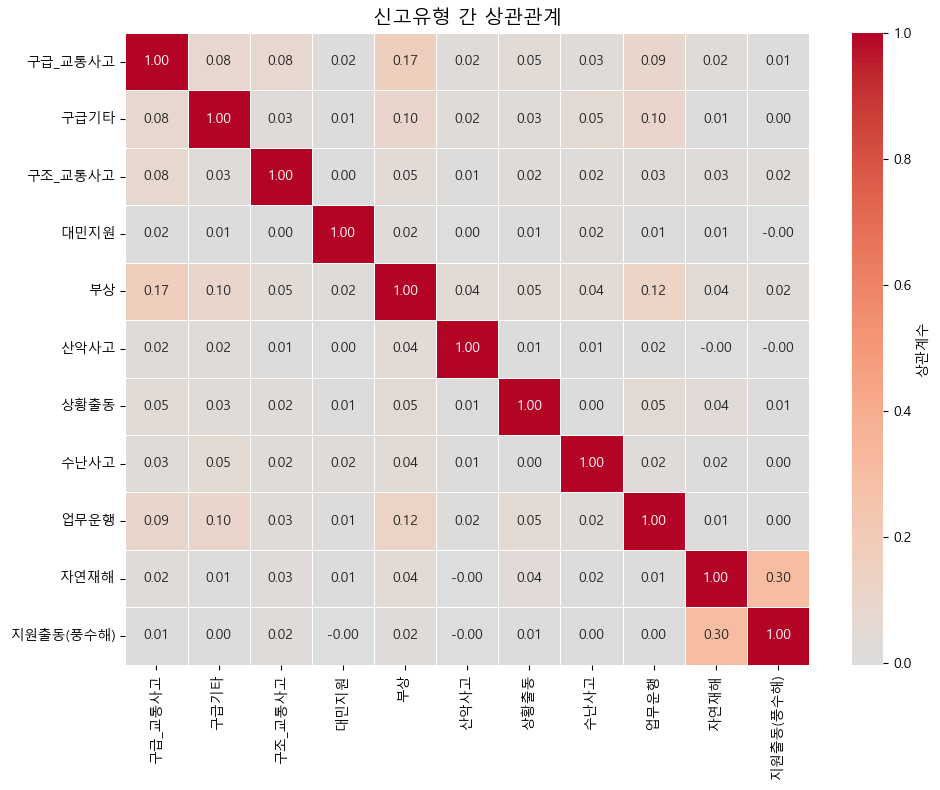

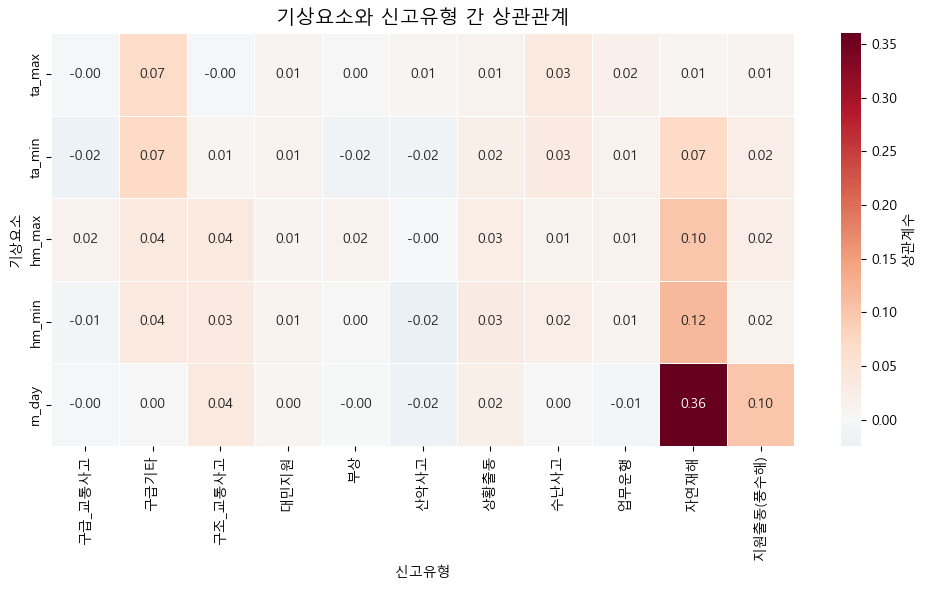


✅ 신고유형 간 평균 상관계수 요약:
부상           0.15
구급_교통사고      0.14
구급기타         0.13
자연재해         0.13
업무운행         0.13
구조_교통사고      0.12
지원출동(풍수해)    0.12
상황출동         0.11
수난사고         0.11
산악사고         0.10
대민지원         0.10
dtype: float64

✅ 기상요소와 신고유형 간 평균 상관계수 요약:
자연재해         0.13
지원출동(풍수해)    0.04
구급기타         0.04
상황출동         0.02
구조_교통사고      0.02
수난사고         0.02
대민지원         0.01
업무운행         0.01
구급_교통사고     -0.00
부상           0.00
산악사고        -0.01
dtype: float64


In [6]:
# correlation

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# 1. 데이터 로드
# ===============================
df = pd.read_csv('train_onehot_log1p.csv')

# ===============================
# 2. 한글 폰트 설정
# ===============================
plt.rc('font', family='Malgun Gothic')  # Windows: 맑은 고딕 / Mac은 AppleGothic
plt.rc('axes', unicode_minus=False)     # 마이너스 깨짐 방지

# ===============================
# 3. 분석 대상 컬럼 정의
# ===============================
# 신고유형 (Target 변수들)
target_cols = [
    '구급_교통사고', '구급기타', '구조_교통사고',
    '대민지원', '부상', '산악사고', '상황출동',
    '수난사고', '업무운행', '자연재해', '지원출동(풍수해)'
]

# 기상 관련 변수
weather_cols = ['ta_max', 'ta_min', 'hm_max', 'hm_min', 'rn_day']

# ===============================
# 4. 신고유형 간 상관분석
# ===============================
corr_targets = df[target_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_targets,
    annot=True, fmt=".2f",
    cmap='coolwarm', center=0,
    linewidths=0.5, cbar_kws={'label': '상관계수'}
)
plt.title('신고유형 간 상관관계', fontsize=14)
plt.tight_layout()
plt.savefig('output_corr_target.png', dpi=300)
plt.show()

# ===============================
# 5. 기상요소 ↔ 신고유형 상관분석
# ===============================
subset = df[weather_cols + target_cols]
corr_weather = subset.corr()
corr_focus = corr_weather.loc[weather_cols, target_cols]

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_focus,
    annot=True, fmt=".2f",
    cmap='RdBu_r', center=0,
    linewidths=0.5, cbar_kws={'label': '상관계수'}
)
plt.title('기상요소와 신고유형 간 상관관계', fontsize=14)
plt.xlabel('신고유형')
plt.ylabel('기상요소')
plt.tight_layout()
plt.savefig('output_corr_weather.png', dpi=300)
plt.show()

# ===============================
# 6. 결과 요약 출력 (해석용)
# ===============================
print("\n✅ 신고유형 간 평균 상관계수 요약:")
print(corr_targets.mean().round(2).sort_values(ascending=False))

print("\n✅ 기상요소와 신고유형 간 평균 상관계수 요약:")
print(corr_focus.mean().round(2).sort_values(ascending=False))

In [7]:
# PCA preprocess

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def pca_pop() :
    file_path = "법정동별_인구통계.csv"
    df = pd.read_csv(file_path, encoding="euc-kr")
    cols = ["65세이상남자", "65세이상여자", "총인구남자", "총인구여자"]
    tb = df[cols].dropna()

    # 표준화
    scaler = StandardScaler()
    tb_scaled = scaler.fit_transform(tb)

    # PCA
    pca = PCA(n_components=3)
    pca_tb = pca.fit_transform(tb_scaled)

    df_pca = pd.DataFrame(
        pca_tb,
        columns=["total_pop", "oldery_ratio", "gender_ratio"]
    )
    keep_cols = ["시점", "지역동"]
    pop_pca = pd.concat([df[keep_cols].reset_index(drop=True), df_pca], axis=1)
    pop_pca["call119_train.address_gu"] = None
    pop_pca.loc[pop_pca['지역동'] == '송정동_강서구', ['지역동', 'call119_train.address_gu']] = ['송정동', '강서구']
    pop_pca.loc[pop_pca['지역동'] == '송정동_해운대구', ['지역동', 'call119_train.address_gu']] = ['송정동', '해운대구']
    pop_pca.rename(columns={'시점': 'call119_train.tm', '지역동': 'call119_train.sub_address'}, inplace=True)

    return pop_pca

def pca_weather() :
    df = pd.read_csv("train_call_119.csv")
    cols=["call119_train.ta_max",
        "call119_train.ta_min",
        "call119_train.ta_max_min",
        "call119_train.hm_min",
        "call119_train.hm_max",
        "call119_train.ws_max",
        "call119_train.ws_ins_max",
        "call119_train.rn_day"
        ]
    df = df.replace(-99, np.nan)
    tb = df[cols].interpolate(method='linear')

    # 기온
    temp_vars = ["call119_train.ta_max", "call119_train.ta_min", "call119_train.ta_max_min"]

    scaler_temp = StandardScaler()
    X_temp_scaled = scaler_temp.fit_transform(tb[temp_vars])

    pca_temp = PCA(n_components=1)
    temp_pc = pca_temp.fit_transform(X_temp_scaled)

    pc_temp = pd.DataFrame(
        temp_pc,
        columns=["temp_axis"]
    )

    #습도
    humid_vars = ["call119_train.hm_min", "call119_train.hm_max", "call119_train.rn_day"]

    scaler_humid = StandardScaler()
    X_humid_scaled = scaler_humid.fit_transform(tb[humid_vars])

    pca_humid = PCA(n_components=1)
    humid_pc = pca_humid.fit_transform(X_humid_scaled)

    pc_humid = pd.DataFrame(
        humid_pc,
        columns=["humid_axis"]
    )

    #풍속
    wind_vars = ["call119_train.ws_max", "call119_train.ws_ins_max"]

    scaler_wind = StandardScaler()
    X_wind_scaled = scaler_wind.fit_transform(tb[wind_vars])

    pca_wind = PCA(n_components=1)
    wind_pc = pca_wind.fit_transform(X_wind_scaled)

    pc_wind = pd.DataFrame(
        wind_pc,
        columns=["wind_axis"]
    )

    keep_cols = [
        "call119_train.tm",
        "call119_train.address_city",
        "call119_train.address_gu",
        "call119_train.sub_address",
        "call119_train.stn",
        "temp_axis",
        "humid_axis",
        "wind_axis",
        "call119_train.call_count"
        ]
    df_result = pd.concat([df.reset_index(drop=True), pc_temp, pc_humid, pc_wind], axis=1)[keep_cols]
    df_result['call119_train.sub_address'] = df_result['call119_train.sub_address'].replace({
    '일광면': '일광읍',
    '정관면': '정관읍'
    })

    return df_result

A = pca_weather()
B = pca_pop()

a = "call119_train.tm"
b = "call119_train.address_gu"
c = "call119_train.sub_address"


A[a] = pd.to_datetime(A[a].astype(str), format='%Y%m%d', errors='coerce')

A[a] = pd.to_datetime(A[a])
B[a] = pd.to_datetime(B[a])
A['year_month'] = A[a].dt.to_period('M')
B['year_month'] = B[a].dt.to_period('M')

B_has_y = B[B[b].notna()]
B_none_y = B[B[b].isna()]

merged_has_y = pd.merge(A, B_has_y, on=['year_month', c, b], how='left', suffixes=('', '_dup'))
merged_none_y = pd.merge(A, B_none_y, on=['year_month', c], how='left', suffixes=('', '_dup'))
merged_none_y = merged_none_y.drop(columns=['call119_train.address_gu_dup'])

merged_final = merged_none_y.combine_first(merged_has_y)
merged_final = merged_final.drop(columns=['year_month', 'call119_train.tm_dup'])
merged_final.to_csv('pca_data.csv', index=False, encoding='utf-8-sig')
print(merged_final)

      call119_train.tm call119_train.address_city call119_train.address_gu  \
0           2020-05-01                      부산광역시                      강서구   
1           2020-05-01                      부산광역시                      강서구   
2           2020-05-01                      부산광역시                      금정구   
3           2020-05-01                      부산광역시                      금정구   
4           2020-05-01                      부산광역시                      금정구   
...                ...                        ...                      ...   
42919       2023-10-31                      부산광역시                     해운대구   
42920       2023-10-31                      부산광역시                     해운대구   
42921       2023-10-31                      부산광역시                     해운대구   
42922       2023-10-31                      부산광역시                     해운대구   
42923       2023-10-31                      부산광역시                     해운대구   

      call119_train.sub_address  call119_train.stn  temp_axis  

In [8]:
# linear model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("=== 선형회귀 모델 실행 시작 ===")

# 1️. 데이터 로드
df_pca = pd.read_csv('pca_data.csv')            # PCA 전처리된 데이터
df_raw = pd.read_csv('train_unscaled.csv')      # 실제 신고유형 포함된 원본 데이터

# 날짜 형식 통일
df_pca['call119_train.tm'] = pd.to_datetime(df_pca['call119_train.tm'], errors='coerce')
df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce')

# 주소 매칭 통일
df_pca.rename(columns={
    'call119_train.address_gu': 'address_gu',
    'call119_train.sub_address': 'sub_address'
}, inplace=True)

# 병합 기준
merge_keys = ['address_gu', 'sub_address']

# 월 단위 병합용 컬럼 생성
df_pca['year_month'] = df_pca['call119_train.tm'].dt.to_period('M')
df_raw['year_month'] = df_raw['date'].dt.to_period('M')

# 병합
df = pd.merge(df_raw, df_pca, on=merge_keys + ['year_month'], how='left')

# NaN 제거
df = df.dropna(subset=['call_count'])
print(f"데이터 병합 완료: {len(df)}행")


# 2️. 총 신고건수 예측
base_features = [
    'temp_axis', 'humid_axis', 'wind_axis',
    'total_pop', 'oldery_ratio', 'gender_ratio',
    'is_dayoff', 'typhoon_impact', 'beach_open'
]
target_total = 'call_count'

X = df[base_features]
y = df[target_total]

# 결측치 처리 추가
X = X.fillna(X.mean())
y = y.fillna(y.mean())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lr_total = LinearRegression()
lr_total.fit(X_train, y_train)
pred_total = lr_total.predict(X_val)

rmse_total = np.sqrt(mean_squared_error(y_val, pred_total))
r2_total = r2_score(y_val, pred_total)

print("\n=== [1] 총 신고건수 예측 ===")
print(f"RMSE: {rmse_total:.3f}")
print(f"R²: {r2_total:.3f}")

coef_df_total = pd.DataFrame({
    'Feature': base_features,
    'Coefficient': lr_total.coef_
}).sort_values(by='Coefficient', ascending=False)
print("\n[회귀계수 중요도 - 총 신고건수]")
print(coef_df_total)


# 3️. 신고유형별 영향 분석
category_cols = [
    '구급_교통사고', '구급기타', '구조_교통사고', '대민지원',
    '부상', '산악사고', '상황출동', '수난사고', '업무운행', '자연재해', '지원출동(풍수해)'
]

existing_targets = [col for col in category_cols if col in df.columns]

print("\n=== [2] 신고유형별 영향 분석 ===")
for target in existing_targets:
    X = df[base_features]
    y = df[target]

    # 결측치 처리 추가
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, pred))
    r2 = r2_score(y_val, pred)

    print(f"\n▶ {target}")
    print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")

    coef_df = pd.DataFrame({
        'Feature': base_features,
        'Coefficient': lr.coef_
    }).sort_values(by='Coefficient', ascending=False)
    print(coef_df)


# 4️. 이벤트 변수 영향 분석
event_features = ['is_dayoff', 'typhoon_impact', 'beach_open']

print("\n=== [3] 이벤트 변수 영향 분석 ===")
for ev in event_features:
    X_ev = df[[ev]]
    y_ev = df[target_total]
    lr_ev = LinearRegression().fit(X_ev, y_ev)
    coef = lr_ev.coef_[0]
    print(f"{ev}: {coef:.4f}")


# 5️. 결과 저장
coef_df_total.to_csv('linear_model_total_coefficients.csv', index=False, encoding='utf-8-sig')
print("\n결과 저장 완료: linear_model_total_coefficients.csv")
print("=== 분석 종료 ===")


=== 선형회귀 모델 실행 시작 ===
데이터 병합 완료: 1299375행

=== [1] 총 신고건수 예측 ===
RMSE: 1.847
R²: 0.163

[회귀계수 중요도 - 총 신고건수]
          Feature  Coefficient
7  typhoon_impact     1.471276
8      beach_open     0.648118
3       total_pop     0.364432
5    gender_ratio     0.254708
4    oldery_ratio     0.066048
0       temp_axis     0.034181
1      humid_axis     0.009242
2       wind_axis     0.002551
6       is_dayoff    -0.136645

=== [2] 신고유형별 영향 분석 ===

▶ 구급_교통사고
RMSE: 0.597, R²: 0.064
          Feature  Coefficient
8      beach_open     0.098626
3       total_pop     0.071260
1      humid_axis    -0.001631
2       wind_axis    -0.004273
0       temp_axis    -0.004445
5    gender_ratio    -0.018277
6       is_dayoff    -0.023456
7  typhoon_impact    -0.036177
4    oldery_ratio    -0.059911

▶ 구급기타
RMSE: 0.396, R²: 0.045
          Feature  Coefficient
8      beach_open     0.070120
3       total_pop     0.034156
0       temp_axis     0.030114
5    gender_ratio     0.018033
4    oldery_ratio     0.002

In [9]:
# %% KNN 모델 (K-Nearest Neighbors)
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)


print("=== KNN 모델 실행 시작 ===")

# 1. 데이터 로드
print("\n[1] 데이터 로드 중...")
try:
    # 전처리된 데이터 로드 (OneHot 인코딩 + log1p 변환된 데이터)
    df = pd.read_csv('train_onehot_log1p.csv', index_col=0)
    print(f"✅ train_onehot_log1p.csv 로드 완료: {df.shape}")
except FileNotFoundError:
    # 대체 파일 시도
    df = pd.read_csv('train_clustered.csv', index_col=0)
    print(f"✅ train_clustered.csv 로드 완료: {df.shape}")

# 원본 데이터도 로드 (분석용 - 날씨/이벤트 정보 유지)
try:
    df_original = pd.read_csv('train_clustered.csv', index_col=0)
    print(f"✅ 원본 데이터 로드 완료: {df_original.shape}")
except FileNotFoundError:
    df_original = df.copy()
    print("⚠️ 원본 데이터를 찾을 수 없어 현재 데이터 사용")

# 2. 불필요한 컬럼 제거
print("\n[2] 특징 선택 중...")
drop_cols = ['date', 'sub_address', 'address_gu']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 추가로 제거할 컬럼들
optional_drop = [
    'ta_max_lag1', 'ta_max_lag2', 'ta_min_lag1', 'ta_min_lag2',
    'ta_max_min_lag1', 'ta_max_min_lag2', 'hm_min_lag1', 'hm_min_lag2',
    'hm_max_lag1', 'hm_max_lag2', 'ws_max_lag1', 'ws_max_lag2',
    'ws_ins_max_lag1', 'ws_ins_max_lag2', 'rn_day_lag1', 'rn_day_lag2',
    'distancing_strength_lag1', 'distancing_strength_lag2',
    'beach_open_lag1', 'beach_open_lag2', 'real_ta_lag1', 'real_ta_lag2',
    'typhoon_impact_lag1', 'typhoon_impact_lag2', 'cluster', '위도', '경도'
]

df = df.drop(columns=[c for c in optional_drop if c in df.columns], errors='ignore')

# 3. 타겟 변수 정의
target_columns = [
    '구급_교통사고', '구급기타', '구조_교통사고',
    '대민지원', '부상', '산악사고', '상황출동', '수난사고',
    '업무운행', '자연재해', '지원출동(풍수해)'
]

# 실제 존재하는 타겟 컬럼만 선택
existing_targets = [col for col in target_columns if col in df.columns]
target_total = 'call_count' if 'call_count' in df.columns else None

print(f"타겟 변수: 총 {len(existing_targets)}개 신고유형")
if target_total:
    print(f"총 신고건수 예측 포함")

# 4. 입력 피처와 타겟 분리
X = df.drop(columns=existing_targets + ([target_total] if target_total else []), errors='ignore')
y_total = df[target_total] if target_total else None

# 결측치 처리
X = X.fillna(X.mean())
if y_total is not None:
    y_total = y_total.fillna(y_total.mean())

print(f"입력 피처 수: {X.shape[1]}")
print(f"샘플 수: {X.shape[0]}")

# 5. 데이터 스케일링 (KNN은 거리 기반이므로 스케일링 중요)
print("\n[3] 데이터 스케일링 중...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# 6. 총 신고건수 예측 (KNN)
if target_total:
    print("\n=== [1] 총 신고건수 예측 (KNN) ===")
    print("전체 데이터로 학습 중...")

    # 하이퍼파라미터 튜닝 (전체 데이터 사용)
    print("하이퍼파라미터 튜닝 중...")

    # 축소된 파라미터 그리드
    param_grid = {
        'n_neighbors': [5, 10, 15],  # 6개 -> 3개로 축소
        'weights': ['uniform', 'distance']
        # metric 제거 (euclidean이 기본값이고 일반적으로 더 빠름)
    }

    knn_base = KNeighborsRegressor()
    grid_search = GridSearchCV(
        knn_base, param_grid, cv=3,  # cv=5 -> 3으로 축소
        scoring='neg_mean_squared_error',
        n_jobs=-1, verbose=0
    )
    grid_search.fit(X_scaled, y_total)

    print(f"최적 파라미터: {grid_search.best_params_}")
    print(f"최적 CV 점수: {-grid_search.best_score_:.3f} (RMSE)")

    # 최적 파라미터 저장 (결과 저장용)
    best_params_total = grid_search.best_params_

    # 최적 파라미터로 전체 데이터로 학습
    knn_total = KNeighborsRegressor(**best_params_total)
    knn_total.fit(X_scaled, y_total)

    print(f"\n[총 신고건수 예측 모델 학습 완료]")
    print(f"학습 데이터 수: {len(X_scaled)}개")
    print(f"최적 파라미터: {best_params_total}")

# 7. 신고유형별 예측
print("\n=== [2] 신고유형별 예측 (KNN) ===")

results = []

for target in existing_targets:
    print(f"\n▶ {target} 예측 중...")

    y = df[target].fillna(df[target].mean())

    # 하이퍼파라미터 튜닝 (전체 데이터 사용)
    # 더 작은 파라미터 그리드
    param_grid_simple = {
        'n_neighbors': [5, 10],  # 3개 -> 2개로 축소
        'weights': ['distance']  # distance가 일반적으로 더 좋은 성능
    }

    knn = KNeighborsRegressor()
    grid_search = GridSearchCV(
        knn, param_grid_simple, cv=2,  # cv=3 -> 2로 축소
        scoring='neg_mean_squared_error',
        n_jobs=-1, verbose=0
    )
    grid_search.fit(X_scaled, y)

    # 최적 파라미터로 전체 데이터로 학습
    knn_model = KNeighborsRegressor(**grid_search.best_params_)
    knn_model.fit(X_scaled, y)

    print(f"  최적 k: {grid_search.best_params_['n_neighbors']}")
    print(f"  학습 완료 (전체 데이터: {len(X_scaled)}개)")

    results.append({
        'Target': target,
        'n_neighbors': grid_search.best_params_['n_neighbors'],
        'weights': grid_search.best_params_['weights']
    })

# 8. 결과 요약
print("\n=== [3] 결과 요약 ===")
results_df = pd.DataFrame(results)
print("\n[신고유형별 예측 성능]")
print(results_df.to_string(index=False))

# 9. 결과 저장
if target_total:
    total_results = pd.DataFrame({
        'Model': ['KNN'],
        'Target': ['call_count'],
        'Best_n_neighbors': [best_params_total['n_neighbors']],
        'Best_weights': [best_params_total['weights']]
    })

    # 총 신고건수와 유형별 결과 병합
    if len(results_df) > 0:
        final_results = pd.concat([total_results, results_df], ignore_index=True)
    else:
        final_results = total_results
else:
    final_results = results_df

final_results.to_csv('knn_model_results.csv', index=False, encoding='utf-8-sig')
print("\n✅ 결과 저장 완료: knn_model_results.csv")

# ============================================
# 10. 날씨 및 외부 요인에 따른 총 신고건수 예측 분석
# ============================================
print("\n=== [4] 날씨 및 외부 요인별 예측 분석 ===")

if target_total and 'knn_total' in locals():
    # 전체 데이터에 날씨/이벤트 정보 추가
    df_val_analysis = df_original.copy()

    # 인덱스 정렬 (안전하게)
    df_val_analysis = df_val_analysis.sort_index()

    # 날씨 변수 정의
    weather_cols = ['ta_max', 'ta_min', 'hm_max', 'hm_min', 'ws_max', 'rn_day', 'real_ta']
    weather_cols = [col for col in weather_cols if col in df_val_analysis.columns]

    # 이벤트 변수 정의
    event_cols = ['is_dayoff', 'typhoon_impact', 'beach_open', 'distancing_strength']
    event_cols = [col for col in event_cols if col in df_val_analysis.columns]

    # 예측값과 실제값 추가
    pred_total = knn_total.predict(X_scaled)
    pred_total_series = pd.Series(pred_total, index=X_scaled.index).sort_index()
    y_total_series = y_total.sort_index() if hasattr(y_total, 'sort_index') else pd.Series(y_total, index=X_scaled.index).sort_index()

    df_val_analysis['predicted'] = pred_total_series.values
    df_val_analysis['actual'] = y_total_series.values

    # 날씨 구간별 분석
    if 'ta_max' in weather_cols:
        df_val_analysis['temp_category'] = pd.cut(
            df_val_analysis['ta_max'],
            bins=[-np.inf, 10, 20, 25, 30, np.inf],
            labels=['매우추움(≤10)', '추움(10-20)', '보통(20-25)', '따뜻함(25-30)', '더움(>30)']
        )

        weather_analysis = df_val_analysis.groupby('temp_category').agg({
            'actual': ['mean', 'std', 'count'],
            'predicted': ['mean', 'std']
        }).round(2)

        print("\n[온도 구간별 신고건수 분석]")
        print(weather_analysis)
        weather_analysis.to_csv('knn_weather_analysis.csv', encoding='utf-8-sig')

    # 이벤트별 분석
    event_analysis_list = []
    for event_col in event_cols:
        if event_col in df_val_analysis.columns:
            if df_val_analysis[event_col].dtype == bool:
                event_analysis = df_val_analysis.groupby(event_col).agg({
                    'actual': ['mean', 'std', 'count'],
                    'predicted': ['mean', 'std']
                }).round(2)
            else:
                # 태풍 영향도 등 숫자형
                event_analysis = df_val_analysis.groupby(
                    pd.cut(df_val_analysis[event_col], bins=3, labels=['낮음', '보통', '높음'])
                ).agg({
                    'actual': ['mean', 'std', 'count'],
                    'predicted': ['mean', 'std']
                }).round(2)

            print(f"\n[{event_col}별 신고건수 분석]")
            print(event_analysis)
            event_analysis_list.append((event_col, event_analysis))

    # 이벤트 분석 결과 저장
    if event_analysis_list:
        with pd.ExcelWriter('knn_event_analysis.xlsx', engine='openpyxl') as writer:
            for event_col, event_df in event_analysis_list:
                event_df.to_excel(writer, sheet_name=event_col[:31])  # 엑셀 시트명 제한
        print("\n✅ 이벤트 분석 결과 저장: knn_event_analysis.xlsx")

# ============================================
# 11. 신고 유형별 비중 변화와 패턴 분석
# ============================================
print("\n=== [5] 신고 유형별 비중 변화 및 패턴 분석 ===")

if existing_targets and len(results) > 0:
    # 원본 데이터에서 신고 유형별 비중 계산
    df_pattern = df_original.copy()

    # log1p 역변환 (예측값이 log1p 변환된 경우)
    for target in existing_targets:
        if target in df_pattern.columns:
            # 실제값이 log1p 변환되었는지 확인
            if df_pattern[target].min() >= 0:
                # 원본 값으로 가정
                pass

    # 전체 신고건수 대비 각 유형별 비중 계산
    if 'call_count' in df_pattern.columns:
        category_proportions = []

        for target in existing_targets:
            if target in df_pattern.columns:
                proportion = (df_pattern[target] / (df_pattern['call_count'] + 1e-6)).mean() * 100
                category_proportions.append({
                    'Category': target,
                    'Average_Proportion(%)': proportion,
                    'Total_Count': df_pattern[target].sum(),
                    'Average_Count': df_pattern[target].mean()
                })

        proportion_df = pd.DataFrame(category_proportions).sort_values('Average_Proportion(%)', ascending=False)

        print("\n[신고 유형별 평균 비중]")
        print(proportion_df.to_string(index=False))
        proportion_df.to_csv('knn_category_proportions.csv', index=False, encoding='utf-8-sig')

        # 시각화
        plt.figure(figsize=(12, 6))
        plt.barh(proportion_df['Category'], proportion_df['Average_Proportion(%)'])
        plt.xlabel('평균 비중 (%)')
        plt.title('신고 유형별 평균 비중')
        plt.tight_layout()
        plt.savefig('knn_category_proportions.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("\n✅ 비중 시각화 저장: knn_category_proportions.png")

        # 날씨/이벤트별 비중 변화 분석
        if 'ta_max' in df_pattern.columns:
            df_pattern['temp_group'] = pd.cut(
                df_pattern['ta_max'],
                bins=[-np.inf, 15, 25, 30, np.inf],
                labels=['추움(≤15)', '보통(15-25)', '따뜻함(25-30)', '더움(>30)']
            )

            temp_proportion = []
            for target in existing_targets[:5]:  # 상위 5개만
                if target in df_pattern.columns:
                    temp_analysis = df_pattern.groupby('temp_group').apply(
                        lambda x: (x[target] / (x['call_count'] + 1e-6)).mean() * 100
                    )
                    temp_proportion.append({
                        'Category': target,
                        **{f'{idx}': val for idx, val in temp_analysis.items()}
                    })

            if temp_proportion:
                temp_prop_df = pd.DataFrame(temp_proportion)
                print("\n[온도 구간별 신고 유형 비중 변화]")
                print(temp_prop_df.to_string(index=False))
                temp_prop_df.to_csv('knn_temp_category_proportions.csv', index=False, encoding='utf-8-sig')

# ============================================
# 12. 특정 이벤트 상황에서의 신고 양상 예측
# ============================================
print("\n=== [6] 특정 이벤트 상황별 신고 양상 분석 ===")

if target_total and 'knn_total' in locals() and 'actual' in df_val_analysis.columns:
    event_scenarios = {}

    # 태풍 상황
    if 'typhoon_impact' in df_val_analysis.columns:
        typhoon_cases = df_val_analysis[df_val_analysis['typhoon_impact'] > 0]
        if len(typhoon_cases) > 0 and 'actual' in typhoon_cases.columns:
            event_scenarios['태풍_영향'] = {
                'actual_mean': typhoon_cases['actual'].mean(),
                'predicted_mean': typhoon_cases['predicted'].mean() if 'predicted' in typhoon_cases.columns else 0,
                'count': len(typhoon_cases),
                'categories': {}
            }

            # 태풍 시 신고 유형별 변화
            for target in existing_targets[:5]:
                if target in df_original.columns:
                    normal_mean = df_val_analysis[df_val_analysis['typhoon_impact'] == 0][target].mean() if 'typhoon_impact' in df_val_analysis.columns else 0
                    typhoon_mean = typhoon_cases[target].mean() if target in typhoon_cases.columns else 0
                    if normal_mean > 0:
                        change_pct = ((typhoon_mean - normal_mean) / normal_mean) * 100
                        event_scenarios['태풍_영향']['categories'][target] = change_pct

    # 공휴일 상황
    if 'is_dayoff' in df_val_analysis.columns and 'actual' in df_val_analysis.columns:
        holiday_cases = df_val_analysis[df_val_analysis['is_dayoff'] == True]
        if len(holiday_cases) > 0:
            normal_cases = df_val_analysis[df_val_analysis['is_dayoff'] == False]
            if len(normal_cases) > 0 and 'actual' in normal_cases.columns:
                event_scenarios['공휴일'] = {
                    'actual_mean': holiday_cases['actual'].mean(),
                    'normal_mean': normal_cases['actual'].mean(),
                    'change_pct': ((holiday_cases['actual'].mean() - normal_cases['actual'].mean()) / (normal_cases['actual'].mean() + 1e-6)) * 100,
                    'count': len(holiday_cases)
                }

    # 해수욕장 개장 상황
    if 'beach_open' in df_val_analysis.columns and 'actual' in df_val_analysis.columns:
        beach_cases = df_val_analysis[df_val_analysis['beach_open'] == True]
        if len(beach_cases) > 0:
            normal_cases = df_val_analysis[df_val_analysis['beach_open'] == False]
            if len(normal_cases) > 0 and 'actual' in normal_cases.columns:
                event_scenarios['해수욕장_개장'] = {
                    'actual_mean': beach_cases['actual'].mean(),
                    'normal_mean': normal_cases['actual'].mean(),
                    'change_pct': ((beach_cases['actual'].mean() - normal_cases['actual'].mean()) / (normal_cases['actual'].mean() + 1e-6)) * 100,
                    'count': len(beach_cases)
                }

    # 결과 출력 및 저장
    if event_scenarios:
        print("\n[이벤트별 신고 양상]")
        scenario_results = []
        for scenario_name, scenario_data in event_scenarios.items():
            print(f"\n▶ {scenario_name}:")
            if 'actual_mean' in scenario_data:
                print(f"  평균 신고건수: {scenario_data['actual_mean']:.2f}")
            if 'change_pct' in scenario_data:
                print(f"  변화율: {scenario_data['change_pct']:.2f}%")
            if 'categories' in scenario_data:
                print("  신고 유형별 변화:")
                for cat, change in scenario_data['categories'].items():
                    print(f"    {cat}: {change:+.2f}%")

            scenario_results.append({
                'Event': scenario_name,
                **{k: v for k, v in scenario_data.items() if k != 'categories'}
            })

        scenario_df = pd.DataFrame(scenario_results)
        scenario_df.to_csv('knn_event_scenarios.csv', index=False, encoding='utf-8-sig')
        print("\n✅ 이벤트 시나리오 분석 저장: knn_event_scenarios.csv")

print("\n=== KNN 모델 실행 완료 ===")


=== KNN 모델 실행 시작 ===

[1] 데이터 로드 중...
✅ train_onehot_log1p.csv 로드 완료: (99360, 204)
✅ 원본 데이터 로드 완료: (99360, 69)

[2] 특징 선택 중...
타겟 변수: 총 11개 신고유형
총 신고건수 예측 포함
입력 피처 수: 163
샘플 수: 99360

[3] 데이터 스케일링 중...

=== [1] 총 신고건수 예측 (KNN) ===
전체 데이터로 학습 중...
하이퍼파라미터 튜닝 중...
최적 파라미터: {'n_neighbors': 10, 'weights': 'distance'}
최적 CV 점수: 1.701 (RMSE)

[총 신고건수 예측 모델 학습 완료]
학습 데이터 수: 99360개
최적 파라미터: {'n_neighbors': 10, 'weights': 'distance'}

=== [2] 신고유형별 예측 (KNN) ===

▶ 구급_교통사고 예측 중...
  최적 k: 10
  학습 완료 (전체 데이터: 99360개)

▶ 구급기타 예측 중...
  최적 k: 10
  학습 완료 (전체 데이터: 99360개)

▶ 구조_교통사고 예측 중...
  최적 k: 10
  학습 완료 (전체 데이터: 99360개)

▶ 대민지원 예측 중...
  최적 k: 10
  학습 완료 (전체 데이터: 99360개)

▶ 부상 예측 중...
  최적 k: 10
  학습 완료 (전체 데이터: 99360개)

▶ 산악사고 예측 중...
  최적 k: 10
  학습 완료 (전체 데이터: 99360개)

▶ 상황출동 예측 중...
  최적 k: 10
  학습 완료 (전체 데이터: 99360개)

▶ 수난사고 예측 중...
  최적 k: 10
  학습 완료 (전체 데이터: 99360개)

▶ 업무운행 예측 중...
  최적 k: 10
  학습 완료 (전체 데이터: 99360개)

▶ 자연재해 예측 중...
  최적 k: 10
  학습 완료 (전체 데이터: 99360개)

▶ 지원출동(풍수해) 예측 중..

In [10]:
# %% Decision Tree 모델
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
warnings.filterwarnings('ignore')


plt.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)

print("=== Decision Tree 모델 실행 시작 ===")

# 1. 데이터 로드
print("\n[1] 데이터 로드 중...")
try:
    # 전처리된 데이터 로드 (OneHot 인코딩 + log1p 변환된 데이터)
    # PCA 데이터(pca_data.csv)는 사용하지 않음 - 원본 특징 유지
    df = pd.read_csv('train_onehot_log1p.csv', index_col=0)
    print(f"✅ train_onehot_log1p.csv 로드 완료: {df.shape}")
except FileNotFoundError:
    # 대체 파일 시도
    df = pd.read_csv('train_clustered.csv', index_col=0)
    print(f"✅ train_clustered.csv 로드 완료: {df.shape}")

# 원본 데이터도 로드 (분석용 - 날씨/이벤트 정보 유지)
try:
    df_original = pd.read_csv('train_clustered.csv', index_col=0)
    print(f"✅ 원본 데이터 로드 완료: {df_original.shape}")
except FileNotFoundError:
    df_original = df.copy()
    print("⚠️ 원본 데이터를 찾을 수 없어 현재 데이터 사용")

# 2. 불필요한 컬럼 제거
print("\n[2] 특징 선택 중...")
drop_cols = ['date', 'sub_address', 'address_gu']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 추가로 제거할 컬럼들
optional_drop = [
    'ta_max_lag1', 'ta_max_lag2', 'ta_min_lag1', 'ta_min_lag2',
    'ta_max_min_lag1', 'ta_max_min_lag2', 'hm_min_lag1', 'hm_min_lag2',
    'hm_max_lag1', 'hm_max_lag2', 'ws_max_lag1', 'ws_max_lag2',
    'ws_ins_max_lag1', 'ws_ins_max_lag2', 'rn_day_lag1', 'rn_day_lag2',
    'distancing_strength_lag1', 'distancing_strength_lag2',
    'beach_open_lag1', 'beach_open_lag2', 'real_ta_lag1', 'real_ta_lag2',
    'typhoon_impact_lag1', 'typhoon_impact_lag2', 'cluster', '위도', '경도'
]

df = df.drop(columns=[c for c in optional_drop if c in df.columns], errors='ignore')

# 3. 타겟 변수 정의
target_columns = [
    '구급_교통사고', '구급기타', '구조_교통사고',
    '대민지원', '부상', '산악사고', '상황출동', '수난사고',
    '업무운행', '자연재해', '지원출동(풍수해)'
]

# 실제 존재하는 타겟 컬럼만 선택
existing_targets = [col for col in target_columns if col in df.columns]
target_total = 'call_count' if 'call_count' in df.columns else None

print(f"타겟 변수: 총 {len(existing_targets)}개 신고유형")
if target_total:
    print(f"총 신고건수 예측 포함")

# 4. 입력 피처와 타겟 분리
X = df.drop(columns=existing_targets + ([target_total] if target_total else []), errors='ignore') # 독립변수(입력feature)
y_total = df[target_total] if target_total else None # 종속변수(총 신고건수 -> 출력target)

# 결측치 처리
X = X.fillna(X.mean())
if y_total is not None:
    y_total = y_total.fillna(y_total.mean())

print(f"입력 피처 수: {X.shape[1]}")
print(f"샘플 수: {X.shape[0]}")

# 5. 총 신고건수 예측 (Decision Tree)
if target_total:
    print("\n=== [1] 총 신고건수 예측 (Decision Tree) ===")
    print("전체 데이터로 학습 중...")

    # 하이퍼파라미터 튜닝 (전체 데이터 사용)
    print("하이퍼파라미터 튜닝 중...")

    # Decision Tree 파라미터 그리드
    param_grid = {
        'max_depth': [10, 15, 20, 25, None],  # 깊이 트리 제한 (너무 깊으면 과적합) / None은 제한 없음
        'min_samples_split': [2, 5, 10], # 분할 최소 샘플 수
        'min_samples_leaf': [1, 2, 4] # 리프 최소 샘플 수
    }

    dt_base = DecisionTreeRegressor(random_state=42)
    grid_search = GridSearchCV(
        dt_base, param_grid, cv=3,  # cv=3으로 축소
        scoring='neg_mean_squared_error', # 클수록 좋음
        n_jobs=-1, verbose=0
    )
    grid_search.fit(X, y_total)

    print(f"최적 파라미터: {grid_search.best_params_}")
    print(f"최적 CV 점수: {-grid_search.best_score_:.3f} (RMSE)")

    # 최적 파라미터 저장 (결과 저장용)
    best_params_total = grid_search.best_params_

    # 최적 파라미터로 전체 데이터로 학습
    dt_total = DecisionTreeRegressor(**best_params_total, random_state=42)
    dt_total.fit(X, y_total)

    print(f"\n[총 신고건수 예측 모델 학습 완료]")
    print(f"학습 데이터 수: {len(X)}개")
    print(f"최적 파라미터: {best_params_total}")

    # 특징 중요도 출력
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': dt_total.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)

    print("\n[상위 10개 특징 중요도]")
    print(feature_importance.to_string(index=False))

# 6. 신고유형별 예측
print("\n=== [2] 신고유형별 예측 (Decision Tree) ===")

results = []

for target in existing_targets:
    print(f"\n▶ {target} 예측 중...")

    y = df[target].fillna(df[target].mean())

    # 하이퍼파라미터 튜닝 (전체 데이터 사용)
    # 더 작은 파라미터 그리드
    param_grid_simple = {
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5]
    }

    dt = DecisionTreeRegressor(random_state=42)
    grid_search = GridSearchCV(
        dt, param_grid_simple, cv=2,  # cv=2로 축소
        scoring='neg_mean_squared_error',
        n_jobs=-1, verbose=0
    )
    grid_search.fit(X, y)

    # 최적 파라미터로 전체 데이터로 학습
    dt_model = DecisionTreeRegressor(**grid_search.best_params_, random_state=42)
    dt_model.fit(X, y)

    print(f"  최적 max_depth: {grid_search.best_params_['max_depth']}")
    print(f"  학습 완료 (전체 데이터: {len(X)}개)")

    results.append({
        'Target': target,
        'max_depth': grid_search.best_params_['max_depth'],
        'min_samples_split': grid_search.best_params_['min_samples_split']
    })

# 7. 결과 요약
print("\n=== [3] 결과 요약 ===")
results_df = pd.DataFrame(results)
print("\n[신고유형별 예측 성능]")
print(results_df.to_string(index=False))

# 8. 결과 저장
if target_total:
    total_results = pd.DataFrame({
        'Model': ['DecisionTree'],
        'Target': ['call_count'],
        'Best_max_depth': [best_params_total['max_depth']],
        'Best_min_samples_split': [best_params_total['min_samples_split']]
    })

    # 총 신고건수와 유형별 결과 병합
    if len(results_df) > 0:
        final_results = pd.concat([total_results, results_df], ignore_index=True)
    else:
        final_results = total_results
else:
    final_results = results_df

final_results.to_csv('decisiontree_model_results.csv', index=False, encoding='utf-8-sig')
print("\n✅ 결과 저장 완료: decisiontree_model_results.csv")

# ============================================
# 9. 날씨 및 외부 요인에 따른 총 신고건수 예측 분석
# ============================================
print("\n=== [4] 날씨 및 외부 요인별 예측 분석 ===")

if target_total and 'dt_total' in locals():
    # 전체 데이터에 날씨/이벤트 정보 추가
    df_val_analysis = df_original.copy()

    # 인덱스 정렬 (안전하게)
    df_val_analysis = df_val_analysis.sort_index()

    # 날씨 변수 정의
    weather_cols = ['ta_max', 'ta_min', 'hm_max', 'hm_min', 'ws_max', 'rn_day', 'real_ta']
    weather_cols = [col for col in weather_cols if col in df_val_analysis.columns]

    # 이벤트 변수 정의
    event_cols = ['is_dayoff', 'typhoon_impact', 'beach_open', 'distancing_strength']
    event_cols = [col for col in event_cols if col in df_val_analysis.columns]

    # 예측값과 실제값 추가
    pred_total = dt_total.predict(X)
    pred_total_series = pd.Series(pred_total, index=X.index).sort_index()
    y_total_series = y_total.sort_index() if hasattr(y_total, 'sort_index') else pd.Series(y_total, index=X.index).sort_index()

    df_val_analysis['predicted'] = pred_total_series.values
    df_val_analysis['actual'] = y_total_series.values

    # 날씨 구간별 분석
    if 'ta_max' in weather_cols:
        df_val_analysis['temp_category'] = pd.cut(
            df_val_analysis['ta_max'],
            bins=[-np.inf, 10, 20, 25, 30, np.inf],
            labels=['매우추움(≤10)', '추움(10-20)', '보통(20-25)', '따뜻함(25-30)', '더움(>30)']
        )

        weather_analysis = df_val_analysis.groupby('temp_category').agg({
            'actual': ['mean', 'std', 'count'],
            'predicted': ['mean', 'std']
        }).round(2)

        print("\n[온도 구간별 신고건수 분석]")
        print(weather_analysis)
        weather_analysis.to_csv('decisiontree_weather_analysis.csv', encoding='utf-8-sig')

    # 이벤트별 분석
    event_analysis_list = []
    for event_col in event_cols:
        if event_col in df_val_analysis.columns:
            if df_val_analysis[event_col].dtype == bool:
                event_analysis = df_val_analysis.groupby(event_col).agg({
                    'actual': ['mean', 'std', 'count'],
                    'predicted': ['mean', 'std']
                }).round(2)
            else:
                # 태풍 영향도 등 숫자형
                event_analysis = df_val_analysis.groupby(
                    pd.cut(df_val_analysis[event_col], bins=3, labels=['낮음', '보통', '높음'])
                ).agg({
                    'actual': ['mean', 'std', 'count'],
                    'predicted': ['mean', 'std']
                }).round(2)

            print(f"\n[{event_col}별 신고건수 분석]")
            print(event_analysis)
            event_analysis_list.append((event_col, event_analysis))

    # 이벤트 분석 결과 저장
    if event_analysis_list:
        try:
            with pd.ExcelWriter('decisiontree_event_analysis.xlsx', engine='openpyxl') as writer:
                for event_col, event_df in event_analysis_list:
                    event_df.to_excel(writer, sheet_name=event_col[:31])  # 엑셀 시트명 제한
            print("\n✅ 이벤트 분석 결과 저장: decisiontree_event_analysis.xlsx")
        except ImportError:
            print("\n⚠️ openpyxl이 설치되지 않아 엑셀 저장 건너뜀")

# ============================================
# 10. 신고 유형별 비중 변화와 패턴 분석
# ============================================
print("\n=== [5] 신고 유형별 비중 변화 및 패턴 분석 ===")

if existing_targets and len(results) > 0:
    # 원본 데이터에서 신고 유형별 비중 계산
    df_pattern = df_original.copy()

    # 전체 신고건수 대비 각 유형별 비중 계산
    if 'call_count' in df_pattern.columns:
        category_proportions = []

        for target in existing_targets:
            if target in df_pattern.columns:
                proportion = (df_pattern[target] / (df_pattern['call_count'] + 1e-6)).mean() * 100
                category_proportions.append({
                    'Category': target,
                    'Average_Proportion(%)': proportion,
                    'Total_Count': df_pattern[target].sum(),
                    'Average_Count': df_pattern[target].mean()
                })

        proportion_df = pd.DataFrame(category_proportions).sort_values('Average_Proportion(%)', ascending=False)

        print("\n[신고 유형별 평균 비중]")
        print(proportion_df.to_string(index=False))
        proportion_df.to_csv('decisiontree_category_proportions.csv', index=False, encoding='utf-8-sig')

        # 시각화
        plt.figure(figsize=(12, 6))
        plt.barh(proportion_df['Category'], proportion_df['Average_Proportion(%)'])
        plt.xlabel('평균 비중 (%)')
        plt.title('신고 유형별 평균 비중 (Decision Tree)')
        plt.tight_layout()
        plt.savefig('decisiontree_category_proportions.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("\n✅ 비중 시각화 저장: decisiontree_category_proportions.png")

        # 날씨/이벤트별 비중 변화 분석
        if 'ta_max' in df_pattern.columns:
            df_pattern['temp_group'] = pd.cut(
                df_pattern['ta_max'],
                bins=[-np.inf, 15, 25, 30, np.inf],
                labels=['추움(≤15)', '보통(15-25)', '따뜻함(25-30)', '더움(>30)']
            )

            temp_proportion = []
            for target in existing_targets[:5]:  # 상위 5개만
                if target in df_pattern.columns:
                    temp_analysis = df_pattern.groupby('temp_group').apply(
                        lambda x: (x[target] / (x['call_count'] + 1e-6)).mean() * 100
                    )
                    temp_proportion.append({
                        'Category': target,
                        **{f'{idx}': val for idx, val in temp_analysis.items()}
                    })

            if temp_proportion:
                temp_prop_df = pd.DataFrame(temp_proportion)
                print("\n[온도 구간별 신고 유형 비중 변화]")
                print(temp_prop_df.to_string(index=False))
                temp_prop_df.to_csv('decisiontree_temp_category_proportions.csv', index=False, encoding='utf-8-sig')

# ============================================
# 11. 특정 이벤트 상황에서의 신고 양상 예측
# ============================================
print("\n=== [6] 특정 이벤트 상황별 신고 양상 분석 ===")

if target_total and 'dt_total' in locals() and 'actual' in df_val_analysis.columns:
    event_scenarios = {}

    # 태풍 상황
    if 'typhoon_impact' in df_val_analysis.columns:
        typhoon_cases = df_val_analysis[df_val_analysis['typhoon_impact'] > 0]
        if len(typhoon_cases) > 0 and 'actual' in typhoon_cases.columns:
            event_scenarios['태풍_영향'] = {
                'actual_mean': typhoon_cases['actual'].mean(),
                'predicted_mean': typhoon_cases['predicted'].mean() if 'predicted' in typhoon_cases.columns else 0,
                'count': len(typhoon_cases),
                'categories': {}
            }

            # 태풍 시 신고 유형별 변화
            for target in existing_targets[:5]:
                if target in df_original.columns:
                    normal_mean = df_val_analysis[df_val_analysis['typhoon_impact'] == 0][target].mean() if 'typhoon_impact' in df_val_analysis.columns else 0
                    typhoon_mean = typhoon_cases[target].mean() if target in typhoon_cases.columns else 0
                    if normal_mean > 0:
                        change_pct = ((typhoon_mean - normal_mean) / normal_mean) * 100
                        event_scenarios['태풍_영향']['categories'][target] = change_pct

    # 공휴일 상황
    if 'is_dayoff' in df_val_analysis.columns and 'actual' in df_val_analysis.columns:
        holiday_cases = df_val_analysis[df_val_analysis['is_dayoff'] == True]
        if len(holiday_cases) > 0:
            normal_cases = df_val_analysis[df_val_analysis['is_dayoff'] == False]
            if len(normal_cases) > 0 and 'actual' in normal_cases.columns:
                event_scenarios['공휴일'] = {
                    'actual_mean': holiday_cases['actual'].mean(),
                    'normal_mean': normal_cases['actual'].mean(),
                    'change_pct': ((holiday_cases['actual'].mean() - normal_cases['actual'].mean()) / (normal_cases['actual'].mean() + 1e-6)) * 100,
                    'count': len(holiday_cases)
                }

    # 해수욕장 개장 상황
    if 'beach_open' in df_val_analysis.columns and 'actual' in df_val_analysis.columns:
        beach_cases = df_val_analysis[df_val_analysis['beach_open'] == True]
        if len(beach_cases) > 0:
            normal_cases = df_val_analysis[df_val_analysis['beach_open'] == False]
            if len(normal_cases) > 0 and 'actual' in normal_cases.columns:
                event_scenarios['해수욕장_개장'] = {
                    'actual_mean': beach_cases['actual'].mean(),
                    'normal_mean': normal_cases['actual'].mean(),
                    'change_pct': ((beach_cases['actual'].mean() - normal_cases['actual'].mean()) / (normal_cases['actual'].mean() + 1e-6)) * 100,
                    'count': len(beach_cases)
                }

    # 결과 출력 및 저장
    if event_scenarios:
        print("\n[이벤트별 신고 양상]")
        scenario_results = []
        for scenario_name, scenario_data in event_scenarios.items():
            print(f"\n▶ {scenario_name}:")
            if 'actual_mean' in scenario_data:
                print(f"  평균 신고건수: {scenario_data['actual_mean']:.2f}")
            if 'change_pct' in scenario_data:
                print(f"  변화율: {scenario_data['change_pct']:.2f}%")
            if 'categories' in scenario_data:
                print("  신고 유형별 변화:")
                for cat, change in scenario_data['categories'].items():
                    print(f"    {cat}: {change:+.2f}%")

            scenario_results.append({
                'Event': scenario_name,
                **{k: v for k, v in scenario_data.items() if k != 'categories'}
            })

        scenario_df = pd.DataFrame(scenario_results)
        scenario_df.to_csv('decisiontree_event_scenarios.csv', index=False, encoding='utf-8-sig')
        print("\n✅ 이벤트 시나리오 분석 저장: decisiontree_event_scenarios.csv")

# ============================================
# 12. 특징 중요도 시각화
# ============================================
if target_total and 'dt_total' in locals():
    print("\n=== [7] 특징 중요도 분석 ===")

    # 상위 20개 특징 중요도 시각화
    feature_importance_all = pd.DataFrame({
        'Feature': X.columns,
        'Importance': dt_total.feature_importances_
    }).sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_all['Feature'], feature_importance_all['Importance'])
    plt.xlabel('중요도')
    plt.title('Decision Tree 특징 중요도 (상위 20개)')
    plt.tight_layout()
    plt.savefig('decisiontree_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.close()

    feature_importance_all.to_csv('decisiontree_feature_importance.csv', index=False, encoding='utf-8-sig')
    print("✅ 특징 중요도 저장: decisiontree_feature_importance.csv, decisiontree_feature_importance.png")

print("\n=== Decision Tree 모델 실행 완료 ===")

=== Decision Tree 모델 실행 시작 ===

[1] 데이터 로드 중...
✅ train_onehot_log1p.csv 로드 완료: (99360, 204)
✅ 원본 데이터 로드 완료: (99360, 69)

[2] 특징 선택 중...
타겟 변수: 총 11개 신고유형
총 신고건수 예측 포함
입력 피처 수: 163
샘플 수: 99360

=== [1] 총 신고건수 예측 (Decision Tree) ===
전체 데이터로 학습 중...
하이퍼파라미터 튜닝 중...
최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
최적 CV 점수: 1.798 (RMSE)

[총 신고건수 예측 모델 학습 완료]
학습 데이터 수: 99360개
최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

[상위 10개 특징 중요도]
        Feature  Importance
            총인구    0.246428
        real_ta    0.167112
         ws_max    0.145669
sub_address_연산동    0.080208
     ws_ins_max    0.060851
         rn_day    0.045238
          총인구남자    0.042248
      cluster_3    0.039774
         ta_max    0.039037
sub_address_부전동    0.019300

=== [2] 신고유형별 예측 (Decision Tree) ===

▶ 구급_교통사고 예측 중...
  최적 max_depth: 10
  학습 완료 (전체 데이터: 99360개)

▶ 구급기타 예측 중...
  최적 max_depth: 10
  학습 완료 (전체 데이터: 99360개)

▶ 구조_교통사고 예측 중...
  최적 max_depth: 10
  

In [11]:
# RandomForest 모델


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("=== Fast Random Forest 실행 시작 ===")

# 1. 데이터 로드
print("\n[1] 데이터 로드 중...")
try:
    df = pd.read_csv('train_onehot_log1p.csv', index_col=0)
    print(f"✅ train_onehot_log1p.csv 로드 완료: {df.shape}")
except:
    df = pd.read_csv('train_clustered.csv', index_col=0)
    print(f"⚠️ 대체 데이터 로드: {df.shape}")

df_original = pd.read_csv('train_clustered.csv', index_col=0)

# 2. 컬럼 제거
drop_cols = ['date', 'sub_address', 'address_gu']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

optional_drop = [
    'ta_max_lag1','ta_max_lag2','ta_min_lag1','ta_min_lag2',
    'hm_min_lag1','hm_min_lag2','hm_max_lag1','hm_max_lag2',
    'ws_max_lag1','ws_max_lag2','ws_ins_max_lag1','ws_ins_max_lag2',
    'rn_day_lag1','rn_day_lag2','distancing_strength_lag1','distancing_strength_lag2',
    'beach_open_lag1','beach_open_lag2','real_ta_lag1','real_ta_lag2',
    'typhoon_impact_lag1','typhoon_impact_lag2','cluster','위도','경도'
]
df = df.drop(columns=[c for c in optional_drop if c in df.columns], errors='ignore')

# 3. 타겟 설정
target_cols = [
    '구급_교통사고','구급기타','구조_교통사고','대민지원','부상',
    '산악사고','상황출동','수난사고','업무운행','자연재해','지원출동(풍수해)'
]

existing_targets = [c for c in target_cols if c in df.columns]
target_total = 'call_count'

X = df.drop(columns=existing_targets + [target_total], errors='ignore')
y = df[target_total]

X = X.fillna(X.mean())
y = y.fillna(y.mean())

print(f"입력 피처: {X.shape[1]}")
print(f"샘플 수: {X.shape[0]}")

# ============================
# 4. Train/Val split
# ============================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🔥 튜닝은 전체 데이터의 10%만 사용 (X, y를 동시에 랜덤 샘플링)
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train,
    test_size=0.9,      # 90% 버리고 10%만 튜닝용으로 사용
    random_state=42
)

print(f"튜닝 데이터 크기 → {X_tune.shape}, {y_tune.shape}")


# ============================
# 5. RandomizedSearchCV (빠른 버전)
# ============================

param_distributions = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_distributions,
    n_iter=10,           # 🔥 단 10회만
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\n[튜닝 시작...]")
random_search.fit(X_tune, y_tune)

print("\n[튜닝 완료]")
print("최적 파라미터:", random_search.best_params_)

# ============================
# 6. 최종 학습
# ============================

rf_final = RandomForestRegressor(
    **random_search.best_params_,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train, y_train)
pred = rf_final.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, pred))
r2 = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred)

print(f"\nRMSE = {rmse:.3f}")
print(f"MAE  = {mae:.3f}")
print(f"R²   = {r2:.3f}")

# ============================
# 7. 특징 중요도 저장
# ============================

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_final.feature_importances_
}).sort_values('Importance', ascending=False)

feat_imp.to_csv('fast_randomforest_feature_importance.csv', index=False, encoding='utf-8-sig')

print("\n🔥 실행 완료: fast_randomforest_feature_importance.csv 저장됨")


=== Fast Random Forest 실행 시작 ===

[1] 데이터 로드 중...
✅ train_onehot_log1p.csv 로드 완료: (99360, 204)
입력 피처: 165
샘플 수: 99360
튜닝 데이터 크기 → (7948, 165), (7948,)

[튜닝 시작...]
Fitting 2 folds for each of 10 candidates, totalling 20 fits

[튜닝 완료]
최적 파라미터: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}

RMSE = 1.252
MAE  = 0.689
R²   = 0.497

🔥 실행 완료: fast_randomforest_feature_importance.csv 저장됨


In [12]:
#%%
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

train_scaled = pd.read_csv('train_clustered.csv', index_col=0)
#%%

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(train_scaled[['sub_address']])  # 반드시 train으로만 fit

# 2. train 데이터 인코딩 적용
sub_address_train_encoded = encoder.transform(train_scaled[['sub_address']])

# 3. 인코딩된 결과를 데이터프레임으로 변환 (컬럼 이름도 생성)
encoded_columns = encoder.get_feature_names_out(['sub_address'])
sub_address_train_df = pd.DataFrame(sub_address_train_encoded, columns=encoded_columns, index=train_scaled.index)

# 4. 기존 train 데이터와 병합
train_encoded = pd.concat([train_scaled, sub_address_train_df], axis=1)

# 기존 test 데이터와 병합
train_encoded.to_csv('train_onehot_unlog.csv')


X shape: (99360, 159)
y shape: (99360,)

총 조합 개수: 1

[TimeSeriesSplit Cross-Validation for Cartesian Grid]

=== Config 1/1: max_depth=6, lr=0.05, n_estimators=700 ===
  Fold 1: RMSE=1.2101, MAE=0.6987, R^2=0.3859
  Fold 2: RMSE=1.1867, MAE=0.6835, R^2=0.2962
  Fold 3: RMSE=1.4064, MAE=0.8414, R^2=0.4850
  Fold 4: RMSE=1.3071, MAE=0.6739, R^2=0.4639

[Summary of Hyperparameter Grid Search Results]
   max_depth  learning_rate  n_estimators  mean_rmse  std_rmse  mean_mae  \
0          6           0.05           700   1.277587  0.087003  0.724387   

    std_mae   mean_r2    std_r2  
0  0.068159  0.407755  0.074206  
Saved: xgb_timesplit_grid_results.csv


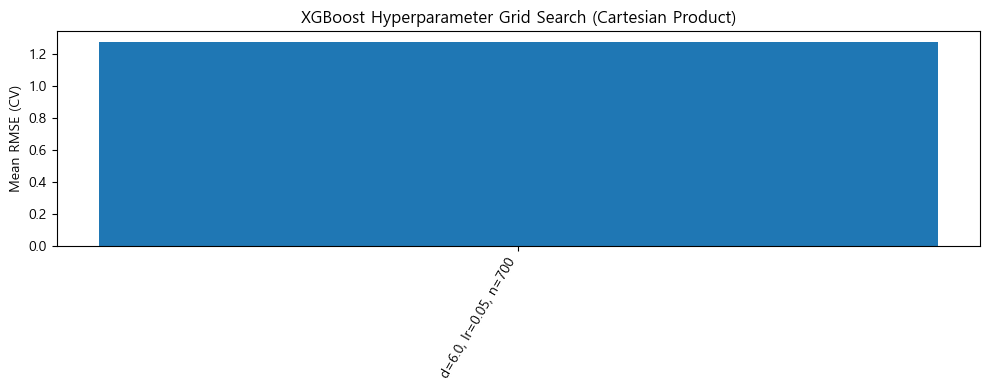

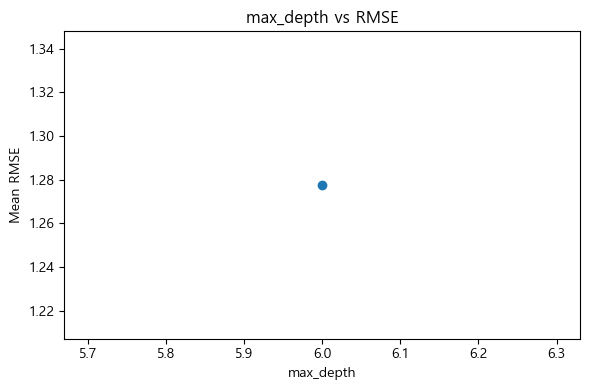

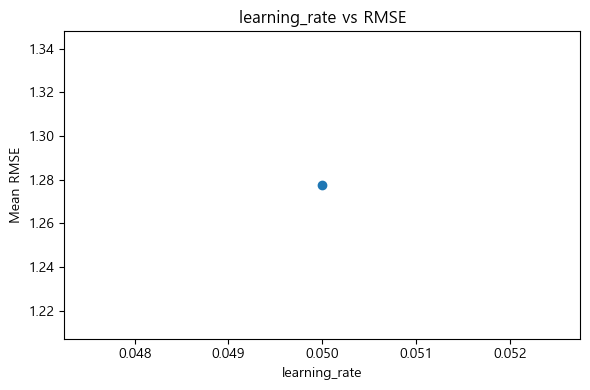

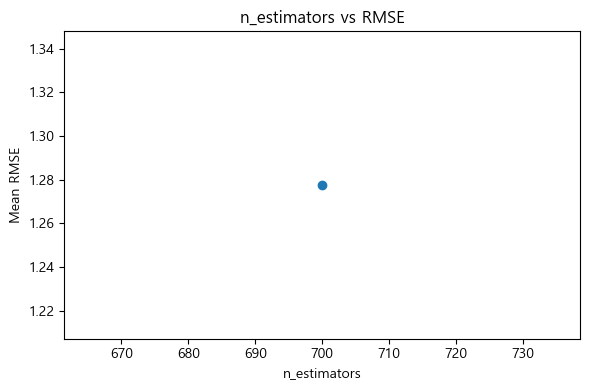

In [13]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from itertools import product  # ✅ 카테시안 곱용

# -----------------------------------------
# 1. 데이터 로드 & 전처리
# -----------------------------------------
train_scaled = pd.read_csv('train_onehot_unlog.csv')

delete_col = ['date','sub_address','address_gu',
    'ta_max_lag1', 'ta_max_lag2', 'ta_min_lag1', 'ta_min_lag2',
    'ta_max_min_lag1', 'ta_max_min_lag2', 'hm_min_lag1', 'hm_min_lag2',
    'hm_max_lag1', 'hm_max_lag2', 'ws_max_lag1', 'ws_max_lag2',
    'ws_ins_max_lag1', 'ws_ins_max_lag2', 'rn_day_lag1', 'rn_day_lag2',
    'distancing_strength_lag1', 'distancing_strength_lag2',
    'beach_open_lag1', 'beach_open_lag2', 'real_ta_lag1', 'real_ta_lag2',
    'typhoon_impact_lag1', 'typhoon_impact_lag2','cluster','위도','경도',
    '65세이상남자','65세이상여자','총인구남자','총인구여자',
    '구급_교통사고', '구급기타', '구조_교통사고',
    '대민지원', '부상', '산악사고', '상황출동', '수난사고',
    '업무운행', '자연재해', '지원출동(풍수해)'
]
train_scaled = train_scaled.drop(columns=delete_col)

TARGET_COL = 'call_count'

if TARGET_COL not in train_scaled.columns:
    raise ValueError(f"TARGET_COL '{TARGET_COL}' 이(가) train_scaled에 없음. 컬럼명을 확인하세요.")

X = train_scaled.drop(columns=[TARGET_COL])
y = train_scaled[TARGET_COL].astype(float)

print("X shape:", X.shape)
print("y shape:", y.shape)

# -----------------------------------------
# 2. 로그 타깃 사용 여부
# -----------------------------------------
use_log_target = False  # True로 바꿔서 한 번 더 실험해도 좋음

if use_log_target:
    y_trans = np.log1p(y)
else:
    y_trans = y

# -----------------------------------------
# 3. 파라미터 리스트 설정 + 카테시안 곱 생성
#    ⚠️ 전체 조합 수 = len(max_depth_list) * len(lr_list) * len(n_estimators_list)
#    너무 많이 넣으면 시간 오래 걸림
# -----------------------------------------
max_depth_list = [6]          # 예: 1~6까지 해도 되지만, 처음엔 3~6 정도로
lr_list        = [0.05]    # learning_rate 후보
n_estim_list   = [700]       # 트리 개수 후보

BASE_PARAMS = {
    "min_child_weight": 1.0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "n_jobs": -1,
}

# 카테시안 곱: (max_depth, lr, n_estimators) 튜플들의 리스트
param_combinations = list(product(max_depth_list, lr_list, n_estim_list))
print(f"\n총 조합 개수: {len(param_combinations)}")
# 예: 4 * 3 * 3 = 36개

# -----------------------------------------
# 4. TimeSeriesSplit 설정
# -----------------------------------------
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# -----------------------------------------
# 5. 각 조합에 대해 CV 실행
# -----------------------------------------
results = []

print("\n[TimeSeriesSplit Cross-Validation for Cartesian Grid]")

for i, (md, lr, ne) in enumerate(param_combinations, 1):
    print(f"\n=== Config {i}/{len(param_combinations)}: max_depth={md}, lr={lr}, n_estimators={ne} ===")
    fold_rmse = []
    fold_mae = []
    fold_r2 = []

    for fold, (tr_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr_t, y_val_t = y_trans.iloc[tr_idx], y_trans.iloc[val_idx]

        model_cv = XGBRegressor(
            n_estimators=ne,
            learning_rate=lr,
            max_depth=md,
            min_child_weight=BASE_PARAMS["min_child_weight"],
            subsample=BASE_PARAMS["subsample"],
            colsample_bytree=BASE_PARAMS["colsample_bytree"],
            objective=BASE_PARAMS["objective"],
            tree_method=BASE_PARAMS["tree_method"],
            random_state=42 + fold + i * 10,
            n_jobs=BASE_PARAMS["n_jobs"],
            eval_metric="rmse",
        )

        model_cv.fit(
            X_tr, y_tr_t,
            eval_set=[(X_val, y_val_t)],
            verbose=False
        )

        val_pred_t = model_cv.predict(X_val)

        if use_log_target:
            y_val = np.expm1(y_val_t)
            val_pred = np.expm1(val_pred_t)
        else:
            y_val = y_val_t
            val_pred = val_pred_t

        mse_f  = mean_squared_error(y_val, val_pred)
        rmse_f = np.sqrt(mse_f)
        mae_f  = mean_absolute_error(y_val, val_pred)
        r2_f   = r2_score(y_val, val_pred)

        fold_rmse.append(rmse_f)
        fold_mae.append(mae_f)
        fold_r2.append(r2_f)

        print(f"  Fold {fold}: RMSE={rmse_f:.4f}, MAE={mae_f:.4f}, R^2={r2_f:.4f}")

    results.append({
        "max_depth": md,
        "learning_rate": lr,
        "n_estimators": ne,
        "mean_rmse": np.mean(fold_rmse),
        "std_rmse": np.std(fold_rmse),
        "mean_mae": np.mean(fold_mae),
        "std_mae": np.std(fold_mae),
        "mean_r2": np.mean(fold_r2),
        "std_r2": np.std(fold_r2),
    })

# -----------------------------------------
# 6. 결과 DataFrame 정리 & 저장
# -----------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("mean_rmse").reset_index(drop=True)

print("\n[Summary of Hyperparameter Grid Search Results]")
print(results_df.head(10))  # 상위 10개만 출력

results_df.to_csv("xgb_timesplit_grid_results.csv", index=False)
print("Saved: xgb_timesplit_grid_results.csv")

# -----------------------------------------
# 7. 시각화: RMSE 기준 비교
# -----------------------------------------

# (1) 조합 인덱스별 바 차트
plt.figure(figsize=(10, 4))
x = np.arange(len(results_df))
labels = [
    f"d={row['max_depth']}, lr={row['learning_rate']}, n={int(row['n_estimators'])}"
    for _, row in results_df.iterrows()
]
plt.bar(x, results_df["mean_rmse"])
plt.xticks(x, labels, rotation=60, ha="right")
plt.ylabel("Mean RMSE (CV)")
plt.title("XGBoost Hyperparameter Grid Search (Cartesian Product)")
plt.tight_layout()
plt.show()

# (2) max_depth vs RMSE (점 많이 찍히는 산점도)
plt.figure(figsize=(6, 4))
plt.scatter(results_df["max_depth"], results_df["mean_rmse"])
plt.xlabel("max_depth")
plt.ylabel("Mean RMSE")
plt.title("max_depth vs RMSE")
plt.tight_layout()
plt.show()

# (3) learning_rate vs RMSE
plt.figure(figsize=(6, 4))
plt.scatter(results_df["learning_rate"], results_df["mean_rmse"])
plt.xlabel("learning_rate")
plt.ylabel("Mean RMSE")
plt.title("learning_rate vs RMSE")
plt.tight_layout()
plt.show()

# (4) n_estimators vs RMSE
plt.figure(figsize=(6, 4))
plt.scatter(results_df["n_estimators"], results_df["mean_rmse"])
plt.xlabel("n_estimators")
plt.ylabel("Mean RMSE")
plt.title("n_estimators vs RMSE")
plt.tight_layout()
plt.show()

Columns after drop: ['ta_max', 'ta_min', 'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'ws_ins_max', 'rn_day', '구급_교통사고', '구급기타'] ...
Feature X shape: (99360, 159)

총 하이퍼파라미터 조합 개수: 1

[Multi-target TimeSeriesSplit Grid Search]

############## Target: 구급_교통사고 ##############

=== Target 구급_교통사고 | Config 1/1: max_depth=6, lr=0.05, n_estimators=700 ===
  Fold 1: RMSE=0.4928, MAE=0.2834, R^2=0.0213
  Fold 2: RMSE=0.4734, MAE=0.2496, R^2=0.0049
  Fold 3: RMSE=0.5260, MAE=0.3045, R^2=0.0560
  Fold 4: RMSE=0.4657, MAE=0.2591, R^2=0.0482

[Best Config for 구급_교통사고]
{'max_depth': 6, 'learning_rate': 0.05, 'n_estimators': 700}
    target  max_depth  learning_rate  n_estimators  mean_rmse  std_rmse  \
0  구급_교통사고          6           0.05           700   0.489471  0.023303   

   mean_mae   std_mae   mean_r2    std_r2  
0  0.274146  0.021423  0.032609  0.020511  

############## Target: 구급기타 ##############

=== Target 구급기타 | Config 1/1: max_depth=6, lr=0.05, n_estimators=700 ===
  Fold 1: RMSE=0.3098

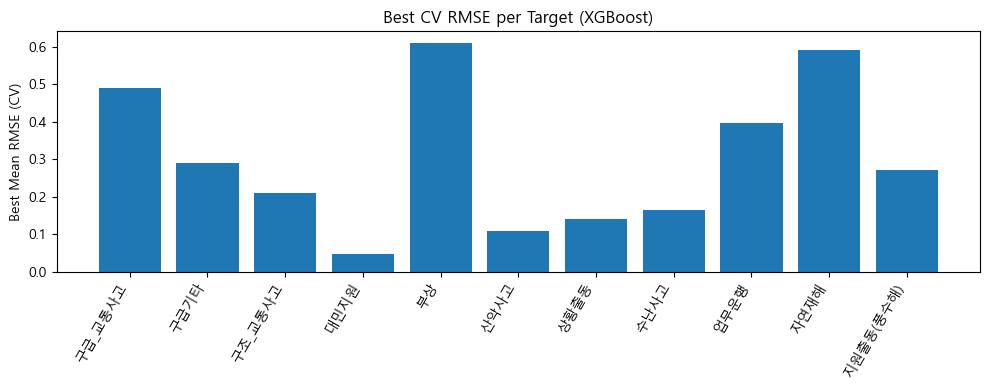

In [14]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from itertools import product

# -----------------------------------------
# 1. 데이터 로드 & 전처리
# -----------------------------------------
train_scaled = pd.read_csv('train_onehot_unlog.csv')

# 다중 타깃으로 예측할 컬럼들
TARGET_COLS = [
    '구급_교통사고', '구급기타', '구조_교통사고',
    '대민지원', '부상', '산악사고', '상황출동', '수난사고',
    '업무운행', '자연재해', '지원출동(풍수해)'
]

# 원래 delete_col 리스트에서, 이제 타깃으로 쓸 컬럼들은 제거(=삭제하지 않음)
raw_delete_col = [
    'date','sub_address','address_gu',
    'ta_max_lag1', 'ta_max_lag2', 'ta_min_lag1', 'ta_min_lag2',
    'ta_max_min_lag1', 'ta_max_min_lag2', 'hm_min_lag1', 'hm_min_lag2',
    'hm_max_lag1', 'hm_max_lag2', 'ws_max_lag1', 'ws_max_lag2',
    'ws_ins_max_lag1', 'ws_ins_max_lag2', 'rn_day_lag1', 'rn_day_lag2',
    'distancing_strength_lag1', 'distancing_strength_lag2',
    'beach_open_lag1', 'beach_open_lag2', 'real_ta_lag1', 'real_ta_lag2',
    'typhoon_impact_lag1', 'typhoon_impact_lag2','cluster','위도','경도','call_count'
]

# 실제로 drop할 컬럼 = 타깃 컬럼들 제외한 raw_delete_col
delete_col = [c for c in raw_delete_col if c not in TARGET_COLS]

# 존재하는 컬럼만 안전하게 삭제
drop_cols_final = [c for c in delete_col if c in train_scaled.columns]
train_scaled = train_scaled.drop(columns=drop_cols_final)

print("Columns after drop:", train_scaled.columns.tolist()[:10], "...")

# -----------------------------------------
# 2. 피처(X) / 타깃(y) 분리
# -----------------------------------------
print("Feature X shape:", X.shape)

# 각 타깃별 y 시리즈 저장
y_dict = {}
for col in TARGET_COLS:
    if col not in train_scaled.columns:
        raise ValueError(f"TARGET_COL '{col}' 이(가) train_scaled에 없음. 컬럼명을 확인하세요.")
    y_dict[col] = train_scaled[col].astype(float)

# -----------------------------------------
# 3. 로그 타깃 사용 여부
# -----------------------------------------
use_log_target = False  # 필요하면 True로 바꿔서 log1p 회귀도 실험 가능

# -----------------------------------------
# 4. 하이퍼파라미터 리스트 설정 + 카테시안 곱 생성
#    (조합 수: len(max_depth_list) * len(lr_list) * len(n_estim_list))
# -----------------------------------------
max_depth_list = [ 6]          # 예: 4와 6 두 가지 깊이
lr_list        = [0.05]    # 예: 0.03, 0.05
n_estim_list   = [700]      # 예: 500, 700

BASE_PARAMS = {
    "min_child_weight": 1.0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "n_jobs": -1,
}

param_combinations = list(product(max_depth_list, lr_list, n_estim_list))
print(f"\n총 하이퍼파라미터 조합 개수: {len(param_combinations)}")

# -----------------------------------------
# 5. TimeSeriesSplit 설정
# -----------------------------------------
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# -----------------------------------------
# 6. 각 타깃별로 CV + 그리드 서치 실행
# -----------------------------------------
all_results = []  # 모든 타깃·조합 결과 저장
best_params_per_target = {}  # 타깃별 best hyperparams

print("\n[Multi-target TimeSeriesSplit Grid Search]")

for target_col in TARGET_COLS:
    print(f"\n############## Target: {target_col} ##############")
    y = y_dict[target_col]

    # 타깃 변환
    if use_log_target:
        y_trans = np.log1p(y)
    else:
        y_trans = y

    target_results = []

    for i, (md, lr, ne) in enumerate(param_combinations, 1):
        print(f"\n=== Target {target_col} | Config {i}/{len(param_combinations)}: "
              f"max_depth={md}, lr={lr}, n_estimators={ne} ===")

        fold_rmse = []
        fold_mae = []
        fold_r2 = []

        for fold, (tr_idx, val_idx) in enumerate(tscv.split(X), 1):
            X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr_t, y_val_t = y_trans.iloc[tr_idx], y_trans.iloc[val_idx]

            model_cv = XGBRegressor(
                n_estimators=ne,
                learning_rate=lr,
                max_depth=md,
                min_child_weight=BASE_PARAMS["min_child_weight"],
                subsample=BASE_PARAMS["subsample"],
                colsample_bytree=BASE_PARAMS["colsample_bytree"],
                objective=BASE_PARAMS["objective"],
                tree_method=BASE_PARAMS["tree_method"],
                random_state=42 + fold + i * 10,
                n_jobs=BASE_PARAMS["n_jobs"],
                eval_metric="rmse",
            )

            model_cv.fit(
                X_tr, y_tr_t,
                eval_set=[(X_val, y_val_t)],
                verbose=False
            )

            val_pred_t = model_cv.predict(X_val)

            if use_log_target:
                y_val = np.expm1(y_val_t)
                val_pred = np.expm1(val_pred_t)
            else:
                y_val = y_val_t
                val_pred = val_pred_t

            mse_f  = mean_squared_error(y_val, val_pred)
            rmse_f = np.sqrt(mse_f)
            mae_f  = mean_absolute_error(y_val, val_pred)
            r2_f   = r2_score(y_val, val_pred)

            fold_rmse.append(rmse_f)
            fold_mae.append(mae_f)
            fold_r2.append(r2_f)

            print(f"  Fold {fold}: RMSE={rmse_f:.4f}, MAE={mae_f:.4f}, R^2={r2_f:.4f}")

        row = {
            "target": target_col,
            "max_depth": md,
            "learning_rate": lr,
            "n_estimators": ne,
            "mean_rmse": np.mean(fold_rmse),
            "std_rmse": np.std(fold_rmse),
            "mean_mae": np.mean(fold_mae),
            "std_mae": np.std(fold_mae),
            "mean_r2": np.mean(fold_r2),
            "std_r2": np.std(fold_r2),
        }
        target_results.append(row)
        all_results.append(row)

    # 타깃별 결과를 DataFrame으로 정리하고, 가장 좋은 조합을 선택
    target_df = pd.DataFrame(target_results)
    target_df = target_df.sort_values("mean_rmse").reset_index(drop=True)
    best_row = target_df.loc[0]

    best_params_per_target[target_col] = {
        "max_depth": int(best_row["max_depth"]),
        "learning_rate": float(best_row["learning_rate"]),
        "n_estimators": int(best_row["n_estimators"]),
    }

    print(f"\n[Best Config for {target_col}]")
    print(best_params_per_target[target_col])
    print(target_df.head())  # 상위 5개 정도 확인용

# -----------------------------------------
# 7. 전체 타깃·파라미터 결과 저장
# -----------------------------------------
all_results_df = pd.DataFrame(all_results)
all_results_df = all_results_df.sort_values(["target", "mean_rmse"]).reset_index(drop=True)

print("\n[Summary of All Targets & Hyperparameters]")
print(all_results_df.head(20))

all_results_df.to_csv("xgb_multi_target_grid_results.csv", index=False)
print("Saved: xgb_multi_target_grid_results.csv")

# -----------------------------------------
# 8. 타깃별 Best RMSE 시각화
# -----------------------------------------
best_rows = []
for tgt in TARGET_COLS:
    sub = all_results_df[all_results_df["target"] == tgt].iloc[0]
    best_rows.append({"target": tgt, "mean_rmse": sub["mean_rmse"], "mean_mae": sub["mean_mae"], "mean_r2": sub["mean_r2"]})

best_df = pd.DataFrame(best_rows)

plt.figure(figsize=(10, 4))
x = np.arange(len(best_df))
plt.bar(x, best_df["mean_rmse"])
plt.xticks(x, best_df["target"], rotation=60, ha="right")
plt.ylabel("Best Mean RMSE (CV)")
plt.title("Best CV RMSE per Target (XGBoost)")
plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =====================================================
# 1. 데이터 로드 & 전처리
# =====================================================
df = pd.read_csv('train_onehot_unlog.csv')

# 종별 타깃들
TYPE_COLS = [
    '구급_교통사고', '구급기타', '구조_교통사고',
    '대민지원', '부상', '산악사고', '상황출동', '수난사고',
    '업무운행', '자연재해', '지원출동(풍수해)'
]

TOTAL_COL = 'call_count'  # 총 신고건수

# 이 컬럼들이 실제로 있는지 확인
for c in TYPE_COLS + [TOTAL_COL]:
    if c not in df.columns:
        raise ValueError(f"컬럼 '{c}' 이(가) 데이터프레임에 없습니다. 컬럼명을 확인하세요.")

# 원래 삭제하던 컬럼들 중에서, 이제는 종별 타깃과 call_count는 살려둠
raw_delete_cols = [
    'date','sub_address','address_gu',
    'ta_max_lag1', 'ta_max_lag2', 'ta_min_lag1', 'ta_min_lag2',
    'ta_max_min_lag1', 'ta_max_min_lag2', 'hm_min_lag1', 'hm_min_lag2',
    'hm_max_lag1', 'hm_max_lag2', 'ws_max_lag1', 'ws_max_lag2',
    'ws_ins_max_lag1', 'ws_ins_max_lag2', 'rn_day_lag1', 'rn_day_lag2',
    'distancing_strength_lag1', 'distancing_strength_lag2',
    'beach_open_lag1', 'beach_open_lag2', 'real_ta_lag1', 'real_ta_lag2',
    'typhoon_impact_lag1', 'typhoon_impact_lag2','cluster','위도','경도',
    # 아래 11개는 타깃이므로 drop 대상에서 제외
    '구급_교통사고', '구급기타', '구조_교통사고',
    '대민지원', '부상', '산악사고', '상황출동', '수난사고',
    '업무운행', '자연재해', '지원출동(풍수해)'
]

delete_cols = [c for c in raw_delete_cols if c not in TYPE_COLS]  # 종별 타깃은 삭제 X
delete_cols = [c for c in delete_cols if c in df.columns]        # 존재하는 것만

df_feat = df.drop(columns=delete_cols)

# 피처 X: call_count 및 종별 타깃은 입력에서 제거
X = df_feat.drop(columns=TYPE_COLS + [TOTAL_COL])
y_total = df_feat[TOTAL_COL].astype(float)
y_types = {col: df_feat[col].astype(float) for col in TYPE_COLS}

print("Feature X shape:", X.shape)
print("Total y shape:", y_total.shape)

# =====================================================
# 2. 공통 하이퍼파라미터 설정
# =====================================================
xgb_params = dict(
    n_estimators=700,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1,
    eval_metric='rmse',
)

use_log_target = False  # 필요하면 True로 바꿔서 log1p 버전도 비교 가능

# =====================================================
# 3. TimeSeriesSplit 기반 비교용 OOF 예측 생성
# =====================================================
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

n_samples = len(X)
oof_direct = np.zeros(n_samples)     # call_count 직접 예측
oof_sum_types = np.zeros(n_samples)  # 종별 예측 합계

print("\n[TimeSeriesSplit: direct call_count vs sum of type-wise predictions]\n")

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X), 1):
    print(f"=== Fold {fold}/{n_splits} ===")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]

    # ----- 3-1. call_count 직접 예측 모델 -----
    if use_log_target:
        y_tr_total = np.log1p(y_total.iloc[tr_idx])
        y_val_total = np.log1p(y_total.iloc[val_idx])
    else:
        y_tr_total = y_total.iloc[tr_idx]
        y_val_total = y_total.iloc[val_idx]

    model_total = XGBRegressor(**xgb_params, random_state=42 + fold * 10)

    model_total.fit(
        X_tr, y_tr_total,
        eval_set=[(X_val, y_val_total)],
        verbose=False
    )

    pred_total_val_t = model_total.predict(X_val)

    if use_log_target:
        pred_total_val = np.expm1(pred_total_val_t)
        y_val_true = y_total.iloc[val_idx]  # 실제 비교는 원래 스케일
    else:
        pred_total_val = pred_total_val_t
        y_val_true = y_total.iloc[val_idx]

    oof_direct[val_idx] = pred_total_val

    # ----- 3-2. 종별 타깃들을 각각 예측 후 합산 -----
    sum_pred_val = np.zeros(len(val_idx), dtype=float)

    for col in TYPE_COLS:
        y_type = y_types[col]

        if use_log_target:
            y_tr_type = np.log1p(y_type.iloc[tr_idx])
            y_val_type = np.log1p(y_type.iloc[val_idx])
        else:
            y_tr_type = y_type.iloc[tr_idx]
            y_val_type = y_type.iloc[val_idx]

        model_type = XGBRegressor(**xgb_params, random_state=1000 + fold * 10 + hash(col) % 100)

        model_type.fit(
            X_tr, y_tr_type,
            eval_set=[(X_val, y_val_type)],
            verbose=False
        )

        pred_type_val_t = model_type.predict(X_val)

        if use_log_target:
            pred_type_val = np.expm1(pred_type_val_t)
        else:
            pred_type_val = pred_type_val_t

        sum_pred_val += pred_type_val  # 종별 예측값 합산

    oof_sum_types[val_idx] = sum_pred_val

# =====================================================
# 4. 최종 성능 비교 (전체 OOF 기준)
# =====================================================
y_true = y_total.values  # 원래 스케일의 call_count

# (1) call_count 직접 예측 성능
mse_direct  = mean_squared_error(y_true, oof_direct)
rmse_direct = np.sqrt(mse_direct)
mae_direct  = mean_absolute_error(y_true, oof_direct)
r2_direct   = r2_score(y_true, oof_direct)

# (2) 종별 합산 예측 성능
mse_sum  = mean_squared_error(y_true, oof_sum_types)
rmse_sum = np.sqrt(mse_sum)
mae_sum  = mean_absolute_error(y_true, oof_sum_types)
r2_sum   = r2_score(y_true, oof_sum_types)

print("\n[Final OOF Performance Comparison]")
print("=== Direct call_count prediction ===")
print(f"RMSE: {rmse_direct:.4f}")
print(f"MAE : {mae_direct:.4f}")
print(f"R^2 : {r2_direct:.44f}")

print("\n=== Sum of type-wise predictions ===")
print(f"RMSE: {rmse_sum:.4f}")
print(f"MAE : {mae_sum:.4f}")
print(f"R^2 : {r2_sum:.4f}")

# =====================================================
# 5. 결과 DataFrame으로 저장 (비교용)
# =====================================================
result_df = pd.DataFrame({
    "call_count_true": y_true,
    "pred_direct": oof_direct,
    "pred_sum_types": oof_sum_types,
})

result_df.to_csv("xgb_compare_direct_vs_sumtypes_oof.csv", index=False)
print("\nSaved: xgb_compare_direct_vs_sumtypes_oof.csv")

# 간단한 상관계수도 찍어볼 수 있음
corr_direct = np.corrcoef(y_true, oof_direct)[0, 1]
corr_sum    = np.corrcoef(y_true, oof_sum_types)[0, 1]
print(f"\nCorrelation (true vs direct):   {corr_direct:.4f}")
print(f"Correlation (true vs sumtypes): {corr_sum:.4f}")


Feature X shape: (99360, 163)
Total y shape: (99360,)

[TimeSeriesSplit: direct call_count vs sum of type-wise predictions]

=== Fold 1/4 ===
=== Fold 2/4 ===
=== Fold 3/4 ===
=== Fold 4/4 ===

[Final OOF Performance Comparison]
=== Direct call_count prediction ===
RMSE: 1.3784
MAE : 0.7527
R^2 : 0.30477228689598123700932319479761645197868347

=== Sum of type-wise predictions ===
RMSE: 1.4621
MAE : 0.7609
R^2 : 0.2177

Saved: xgb_compare_direct_vs_sumtypes_oof.csv

Correlation (true vs direct):   0.5689
Correlation (true vs sumtypes): 0.5184


X shape: (99360, 163)
y shape: (99360,)
Train shape: (79488, 163) (79488,)
Valid shape: (19872, 163) (19872,)

총 하이퍼파라미터 조합 수: 27

[Random Split 기반 XGBoost 하이퍼파라미터 튜닝]

=== Config 1/27: max_depth=4, lr=0.03, n_estimators=500 ===
  → RMSE=1.2176, MAE=0.6814, R^2=0.5243

=== Config 2/27: max_depth=4, lr=0.03, n_estimators=700 ===
  → RMSE=1.2154, MAE=0.6771, R^2=0.5261

=== Config 3/27: max_depth=4, lr=0.03, n_estimators=1000 ===
  → RMSE=1.2145, MAE=0.6731, R^2=0.5267

=== Config 4/27: max_depth=4, lr=0.05, n_estimators=500 ===
  → RMSE=1.2200, MAE=0.6759, R^2=0.5224

=== Config 5/27: max_depth=4, lr=0.05, n_estimators=700 ===
  → RMSE=1.2163, MAE=0.6724, R^2=0.5254

=== Config 6/27: max_depth=4, lr=0.05, n_estimators=1000 ===
  → RMSE=1.2149, MAE=0.6702, R^2=0.5264

=== Config 7/27: max_depth=4, lr=0.07, n_estimators=500 ===
  → RMSE=1.2154, MAE=0.6735, R^2=0.5260

=== Config 8/27: max_depth=4, lr=0.07, n_estimators=700 ===
  → RMSE=1.2133, MAE=0.6717, R^2=0.5277

=== Config 9/27: max_

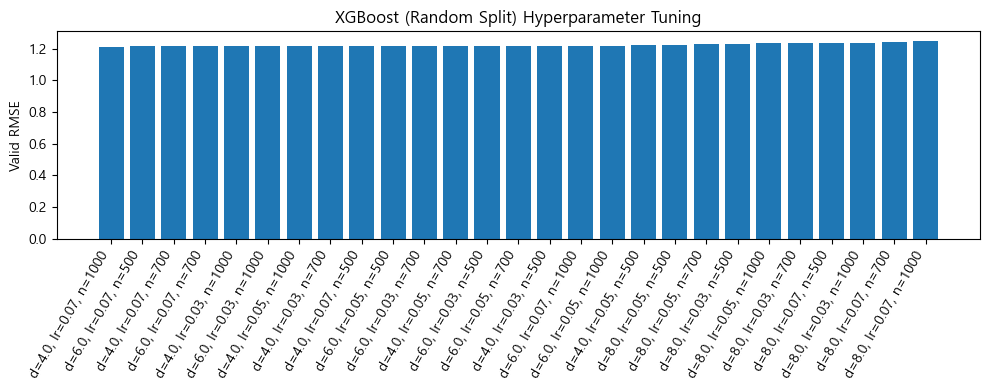

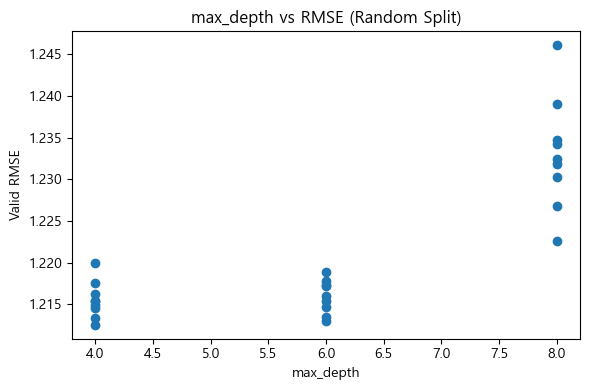

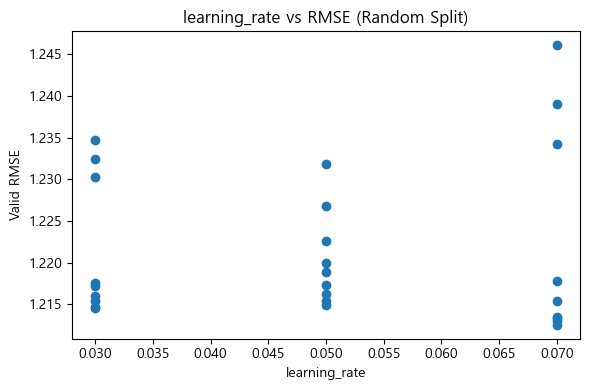

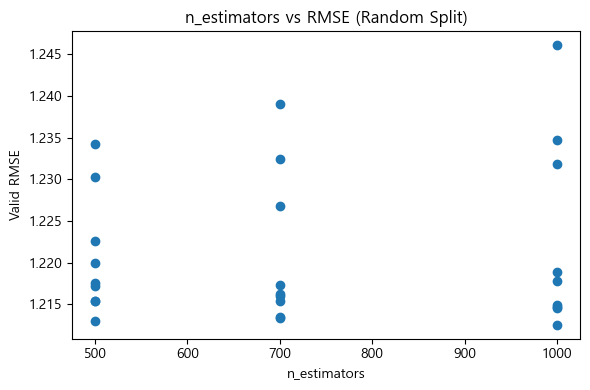


[선택된 최종 하이퍼파라미터]
{'max_depth': 4, 'learning_rate': 0.07, 'n_estimators': 1000}
Saved: train_with_xgb_randomsplit_pred.csv
Saved: xgb_randomsplit_feature_importance.csv


In [16]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from itertools import product

# =====================================================
# 1. 데이터 로드 & 전처리
# =====================================================
df = pd.read_csv('train_onehot_unlog.csv')

# call_count를 예측할 것이므로, 종별 신고 컬럼들은 누수 방지를 위해 피처에서 제거
TARGET_COL = 'call_count'

delete_col = [
    'date','sub_address','address_gu',
    'ta_max_lag1', 'ta_max_lag2', 'ta_min_lag1', 'ta_min_lag2',
    'ta_max_min_lag1', 'ta_max_min_lag2', 'hm_min_lag1', 'hm_min_lag2',
    'hm_max_lag1', 'hm_max_lag2', 'ws_max_lag1', 'ws_max_lag2',
    'ws_ins_max_lag1', 'ws_ins_max_lag2', 'rn_day_lag1', 'rn_day_lag2',
    'distancing_strength_lag1', 'distancing_strength_lag2',
    'beach_open_lag1', 'beach_open_lag2', 'real_ta_lag1', 'real_ta_lag2',
    'typhoon_impact_lag1', 'typhoon_impact_lag2', 'cluster', '위도', '경도',
    # 종별 신고는 call_count의 분해라서 피처에서 제거
    '구급_교통사고', '구급기타', '구조_교통사고',
    '대민지원', '부상', '산악사고', '상황출동', '수난사고',
    '업무운행', '자연재해', '지원출동(풍수해)'
]

# 실제로 존재하는 컬럼만 안전하게 삭제
delete_col = [c for c in delete_col if c in df.columns]
df = df.drop(columns=delete_col)

if TARGET_COL not in df.columns:
    raise ValueError(f"'{TARGET_COL}' 컬럼이 없습니다. 컬럼명을 확인하세요.")

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(float)

print("X shape:", X.shape)
print("y shape:", y.shape)

# =====================================================
# 2. 랜덤 셔플 Train/Valid Split
# =====================================================
RANDOM_STATE = 42
TEST_SIZE = 0.2  # 전체의 20%를 검증용으로 사용

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    shuffle=True,
    random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, y_train.shape)
print("Valid shape:", X_valid.shape, y_valid.shape)

# 로그 타깃 사용할지 여부 (둘 다 돌려보고 더 좋은 쪽 선택해도 됨)
use_log_target = False

if use_log_target:
    y_train_t = np.log1p(y_train)
    y_valid_t = np.log1p(y_valid)
else:
    y_train_t = y_train
    y_valid_t = y_valid

# =====================================================
# 3. 하이퍼파라미터 그리드 정의 (랜덤 셔플 기준 튜닝)
# =====================================================
# → 여기 리스트들만 바꿔서 쉽게 실험 범위를 늘릴 수 있음
max_depth_list = [4, 6, 8]
lr_list        = [0.03, 0.05, 0.07]
n_estim_list   = [500, 700, 1000]

param_combinations = list(product(max_depth_list, lr_list, n_estim_list))
print(f"\n총 하이퍼파라미터 조합 수: {len(param_combinations)}")  # 3*3*3=27개

BASE_PARAMS = {
    "min_child_weight": 1.0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "n_jobs": -1,
}

# =====================================================
# 4. 단일 train/valid Split 기준으로 그리드 서치
# =====================================================
results = []

print("\n[Random Split 기반 XGBoost 하이퍼파라미터 튜닝]")

for i, (md, lr, ne) in enumerate(param_combinations, 1):
    print(f"\n=== Config {i}/{len(param_combinations)}: "
          f"max_depth={md}, lr={lr}, n_estimators={ne} ===")

    model = XGBRegressor(
        n_estimators=ne,
        learning_rate=lr,
        max_depth=md,
        min_child_weight=BASE_PARAMS["min_child_weight"],
        subsample=BASE_PARAMS["subsample"],
        colsample_bytree=BASE_PARAMS["colsample_bytree"],
        objective=BASE_PARAMS["objective"],
        tree_method=BASE_PARAMS["tree_method"],
        n_jobs=BASE_PARAMS["n_jobs"],
        eval_metric="rmse",
        random_state=2025
    )

    model.fit(
        X_train, y_train_t,
        eval_set=[(X_valid, y_valid_t)],
        verbose=False
    )

    # 검증 셋 예측
    y_valid_pred_t = model.predict(X_valid)
    if use_log_target:
        y_valid_pred = np.expm1(y_valid_pred_t)
        y_valid_true = y_valid
    else:
        y_valid_pred = y_valid_pred_t
        y_valid_true = y_valid

    mse  = mean_squared_error(y_valid_true, y_valid_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_valid_true, y_valid_pred)
    r2   = r2_score(y_valid_true, y_valid_pred)

    print(f"  → RMSE={rmse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}")

    results.append({
        "max_depth": md,
        "learning_rate": lr,
        "n_estimators": ne,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    })

# 결과 정리
results_df = pd.DataFrame(results).sort_values("rmse").reset_index(drop=True)
print("\n[하이퍼파라미터 튜닝 결과 상위 10개]")
print(results_df.head(10))

results_df.to_csv("xgb_randomsplit_hparam_results.csv", index=False)
print("Saved: xgb_randomsplit_hparam_results.csv")

# =====================================================
# 5. 시각화 (RMSE 기준 비교)
# =====================================================
plt.figure(figsize=(10, 4))
x = np.arange(len(results_df))
labels = [
    f"d={row['max_depth']}, lr={row['learning_rate']}, n={int(row['n_estimators'])}"
    for _, row in results_df.iterrows()
]
plt.bar(x, results_df["rmse"])
plt.xticks(x, labels, rotation=60, ha="right")
plt.ylabel("Valid RMSE")
plt.title("XGBoost (Random Split) Hyperparameter Tuning")
plt.tight_layout()
plt.show()

# max_depth vs RMSE
plt.figure(figsize=(6, 4))
plt.scatter(results_df["max_depth"], results_df["rmse"])
plt.xlabel("max_depth")
plt.ylabel("Valid RMSE")
plt.title("max_depth vs RMSE (Random Split)")
plt.tight_layout()
plt.show()

# learning_rate vs RMSE
plt.figure(figsize=(6, 4))
plt.scatter(results_df["learning_rate"], results_df["rmse"])
plt.xlabel("learning_rate")
plt.ylabel("Valid RMSE")
plt.title("learning_rate vs RMSE (Random Split)")
plt.tight_layout()
plt.show()

# n_estimators vs RMSE
plt.figure(figsize=(6, 4))
plt.scatter(results_df["n_estimators"], results_df["rmse"])
plt.xlabel("n_estimators")
plt.ylabel("Valid RMSE")
plt.title("n_estimators vs RMSE (Random Split)")
plt.tight_layout()
plt.show()

# =====================================================
# 6. 가장 좋은 설정으로 "전체 train" 재학습 + 예측 저장
# =====================================================
best = results_df.loc[0]
best_params = {
    "max_depth": int(best["max_depth"]),
    "learning_rate": float(best["learning_rate"]),
    "n_estimators": int(best["n_estimators"]),
}
print("\n[선택된 최종 하이퍼파라미터]")
print(best_params)

# 전체 데이터 기준 타깃 변환
if use_log_target:
    y_all_t = np.log1p(y)
else:
    y_all_t = y

final_model = XGBRegressor(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_child_weight=BASE_PARAMS["min_child_weight"],
    subsample=BASE_PARAMS["subsample"],
    colsample_bytree=BASE_PARAMS["colsample_bytree"],
    objective=BASE_PARAMS["objective"],
    tree_method=BASE_PARAMS["tree_method"],
    n_jobs=BASE_PARAMS["n_jobs"],
    eval_metric="rmse",
    random_state=999
)

final_model.fit(X, y_all_t)

# 전체 train에 대한 예측 (분석/ residual 보기용)
train_pred_t = final_model.predict(X)
if use_log_target:
    train_pred = np.expm1(train_pred_t)
else:
    train_pred = train_pred_t

df_out = df.copy()
df_out["pred_call_count"] = train_pred
df_out.to_csv("train_with_xgb_randomsplit_pred.csv", index=False)
print("Saved: train_with_xgb_randomsplit_pred.csv")

# 피처 중요도 저장
fi = pd.DataFrame({
    "feature": X.columns,
    "importance": final_model.feature_importances_
}).sort_values("importance", ascending=False)
fi.to_csv("xgb_randomsplit_feature_importance.csv", index=False)
print("Saved: xgb_randomsplit_feature_importance.csv")
